# **CIS 5450: Final Project: Airbnb**
*Grace Liu, Leah Ning, Yucheng Shao*

# Part 1: Introduction & Background

---
This project focuses on analyzing the key factors influencing Airbnb listing prices and developing predictive models to forecast these prices accurately. The objective is to understand how features like location, amenities, and customer reviews impact pricing and to provide actionable insights for both hosts and guests. By helping hosts set competitive prices to maximize income and giving guests a clearer understanding of pricing trends, the project aims to optimize the Airbnb rental process. Using Airbnb Listings and Reviews data from Kaggle, we primarily worked with the Listings.csv dataset, incorporating review counts from Reviews.csv to enrich our analysis.

Our analysis revealed that Airbnb prices across cities have similar distributions, with Istanbul being objectively the cheapest and Rio de Janeiro the least affordable relative to local residents. Examining prices by reviews, there is a loose positive correlation with a non-linear relationship: high-priced listings cluster in the 90-100 review score range, while lower review scores correspond to lower-priced listings. For review counts, a loose negative correlation was observed, with high variability at low counts and a general trend of decreasing prices as review counts increase. Amenities data showed that Wifi is the most supplied amenity, followed by essentials and "long term stays allowed," with electronics prominently featured among the top 20 amenities, reflecting customer demand. Pricing analysis based on essential amenities showed that fewer than five essential amenities correlate with lower prices, but beyond this threshold, the number of amenities has minimal impact on price. This non-linear relationship may present challenges for predictive modeling using essential amenities as a feature.




# Part 2: Data Loading & Preprocessing

We first import all of the necessary libraries needed to create our models.

In [ ]:
#All necessary imports
import json
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
import matplotlib.pyplot as plt
import folium
import numpy as np
from xgboost import XGBRegressor
from folium.plugins import HeatMap
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from sklearn import datasets, linear_model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from torch.utils import data as data_utils
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
# from sklearn.linear_model import Ridge
from geopy.distance import geodesic
from sklearn.model_selection import KFold, RandomizedSearchCV

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
%%capture
!apt update
!pip install kaggle

## 2.1 Loading Airbnb & Reviews Data

Set up Kaggle API credentials and download the dataset from Kaggle into our notebook.

In [ ]:
#Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Make kaggle directory
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!!kaggle datasets download -d mysarahmadbhat/airbnb-listings-reviews
!unzip /content/airbnb-listings-reviews.zip

Archive:  /content/airbnb-listings-reviews.zip
replace Airbnb Data/Listings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Airbnb Data/Listings.csv  
replace Airbnb Data/Listings_data_dictionary.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Airbnb Data/Listings_data_dictionary.csv  
replace Airbnb Data/Reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Airbnb Data/Reviews.csv  
replace Airbnb Data/Reviews_data_dictionary.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Airbnb Data/Reviews_data_dictionary.csv  


In [ ]:
# Read in airbnb and reviews data
raw_airbnb_df = pd.read_csv('Airbnb Data/Listings.csv', encoding='latin-1')
raw_reviews_df = pd.read_csv('Airbnb Data/Reviews.csv', encoding='latin-1')

<ipython-input-65-5109cf3554e4>:2: DtypeWarning: Columns (5,13) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_airbnb_df = pd.read_csv('Airbnb Data/Listings.csv', encoding='latin-1')


In [ ]:
# Check reviews_df dead, review count, and reviewer count.
print(raw_reviews_df.head())
print("size, " + str(raw_reviews_df.shape))
# count the number of unique review_ids and reviewer_ids
print('Review count: ', raw_reviews_df['review_id'].nunique())
print('Reviewer count: ', raw_reviews_df['reviewer_id'].nunique())

   listing_id  review_id        date  reviewer_id
0       11798  330265172  2018-09-30     11863072
1       15383  330103585  2018-09-30     39147453
2       16455  329985788  2018-09-30      1125378
3       17919  330016899  2018-09-30    172717984
4       26827  329995638  2018-09-30     17542859
size, (5373143, 4)
Review count:  5372983
Reviewer count:  4450005


## 2.2 Data Preprocessing

### 2.2.1 Airbnb Preprocessing

Here we select a subset of columns from `raw_airbnb_df` to create `airbnb_df`, removing unnecessary columns like host response time, host acceptance rate, etc. We also drop rows with missing values to ensure a clean dataset for future modeling.



In [ ]:
# Selecting necessary columns from raw airbnb data, dropping nulls
airbnb_df = raw_airbnb_df[['listing_id', 'host_id', 'host_location', 'neighbourhood', 'city', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'amenities', 'price', 'review_scores_rating']].copy()
airbnb_df.head()
airbnb_df.dropna(inplace=True)

### 2.2.2 Normalize Price to USD

Since the Airbnb listing prices are all in the local currency of the city that the listing is in, we decided to create a mapping of how much 1 unit of the city's currency is equal to in USD. We can then use this mapping to convert all of the listed prices to USD to ensure consistency in all of our future EDA's and models.

In [ ]:
#find number of distinct cities in airbnb_df
print("Number of cities: ", airbnb_df['city'].nunique())

#print how many of each city
print(airbnb_df['city'].value_counts())

# got these conversion rates from Google, whatever sig fig they decided
# will round price column to 2 decimals
conversion_rates = {
    'Paris': 1.05,       # 1 Euro = 1.05 USD (example exchange rate)
    'New York': 1,      # USD to USD is 1:1
    'Bangkok': 0.029,    # 1 Thai Baht = 0.029 USD
    'Rio de Janeiro': 0.17,  # 1 Brazilian Real = 0.17 USD
    'Sydney': 0.64,     # 1 AUD = 0.64 USD
    'Istanbul': 0.029,  # 1 Turkish Lira = 0.029 USD
    'Rome': 1.05,        # Same as Paris, Euro
    'Hong Kong': 0.13,  # 1 HKD = 0.13 USD
    'Mexico City': 0.049,  # 1 Mexican Peso = 0.049 USD
    'Cape Town': 0.055  # 1 South African Rand (ZAR) = 0.055 USD
}

Number of cities:  10
city
Paris             37996
New York          24182
Sydney            20849
Rome              20243
Rio de Janeiro    14886
Mexico City       14039
Cape Town         12371
Istanbul          10404
Bangkok           10023
Hong Kong          3150
Name: count, dtype: int64


In [ ]:
#create copy of price column and name it 'local_price'
if 'local_price' not in airbnb_df.columns:
  airbnb_df['local_price'] = airbnb_df['price'].copy()
airbnb_df['price'] = (airbnb_df['local_price'] * airbnb_df['city'].map(conversion_rates))

### 2.2.3 Dropping Outliers


After converting every price to USD, our current maximum price is \$21,943.60 while our minimum price is \$1.16. Both of these values are unrealistic since they do not reflect a plausible per-night charge for an Airbnb. To address these prices and other outliers, we will calculate the cutoff values for outliers in our dataset.

In [ ]:
print("Maximum price: $", airbnb_df['price'].max())
print("Minimum price: $", airbnb_df['price'].min())

Maximum price: $ 21943.600000000002
Minimum price: $ 1.1600000000000001


We identified outlier prices in the Airbnb dataset using the interquartile range (IQR) method. The upper bound was determined to be $221.3125. Since an Airbnb listing should not be completely free or have a negative price, we will also remove all data points with a price less than \$1. Thus, we adjusted the lower bound, initially calculated as -75.67, to \$1. In total, 12,015 data points would be removed as outliers. However, we believe that 12,015 is too excessive of a number of data points to be removed since that accounts for more than 7% of our original dataset. Therefore, we decided to select a higher cutoff for identifying outliers so we can retain more data points.

In [ ]:
Q1 = airbnb_df['price'].quantile(0.25)
Q3 = airbnb_df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
print("Lower bound:", lower_bound)
upper_bound = Q3 + 1.5 * IQR
print("Upper bound:", upper_bound)

lower_bound = 1

dropped_airbnb_df = airbnb_df[(airbnb_df['price'] >= lower_bound) & (airbnb_df['price'] <= upper_bound)]
print("Number of outliers removed:", airbnb_df.shape[0] - dropped_airbnb_df.shape[0])
#print percentage of dataset the outliers account for
print("Percentage of dataset the outliers account for:",
 ((airbnb_df.shape[0] - dropped_airbnb_df.shape[0]) / airbnb_df.shape[0]) * 100, "%")

Lower bound: -75.6675
Upper bound: 221.3125
Number of outliers removed: 12015
Percentage of dataset the outliers account for: 7.145703359640305 %


Below is a box plot of our original Airbnb dataset, with no removal of outliers yet. As seen in the below boxplot, a major gap in the datapoints occurs at the price of 11,500. Thus, we choose \$11,500 as our new upper bound for prices, and we now only remove 8 outliers.

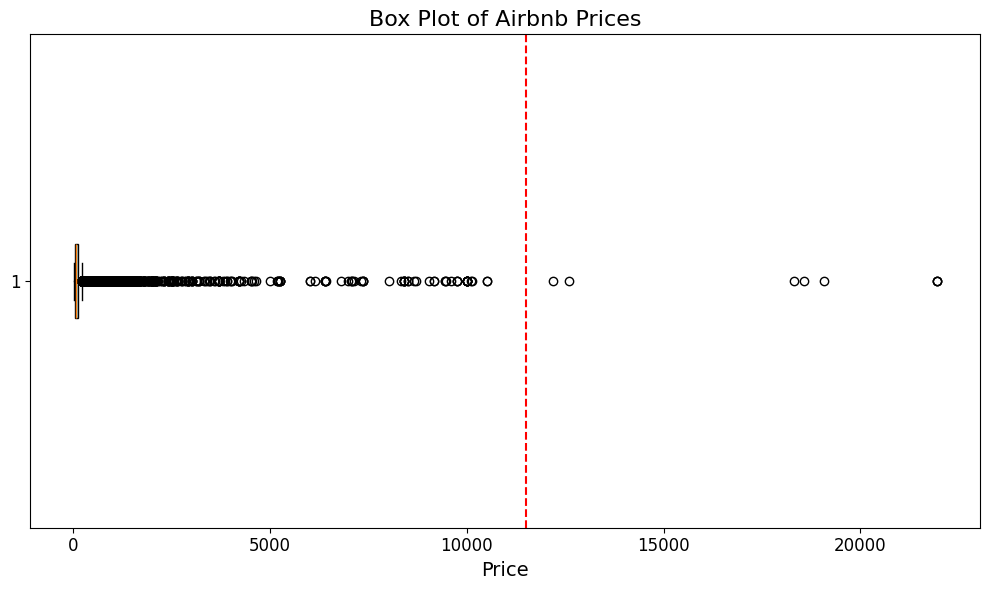

In [ ]:
plt.figure(figsize=(10, 6))
#draw a vertical line at price 11500
plt.axvline(x=11500, color='red', linestyle='--')
plt.boxplot(airbnb_df['price'], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue', color='black'))
plt.title("Box Plot of Airbnb Prices", fontsize=16)
plt.xlabel("Price", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
upper_bound = 11500
print("New upper bound:", upper_bound)
lower_bound = 1

dropped_airbnb_df = airbnb_df[(airbnb_df['price'] >= lower_bound) & (airbnb_df['price'] <= upper_bound)]
print("Number of outliers removed:", airbnb_df.shape[0] - dropped_airbnb_df.shape[0])
#print percentage of dataset the outliers account for
print("Percentage of dataset the outliers account for:",
 ((airbnb_df.shape[0] - dropped_airbnb_df.shape[0]) / airbnb_df.shape[0]) * 100, "%")

New upper bound: 11500
Number of outliers removed: 8
Percentage of dataset the outliers account for: 0.004757854921108818 %


The removed 8 outliers account for only 0.0048% of our dataset, so we wish to remove more outliers. In our new boxplot below, we see another significant gap at the price \$5400. Thus, we will set our new upper bound to \$5400.

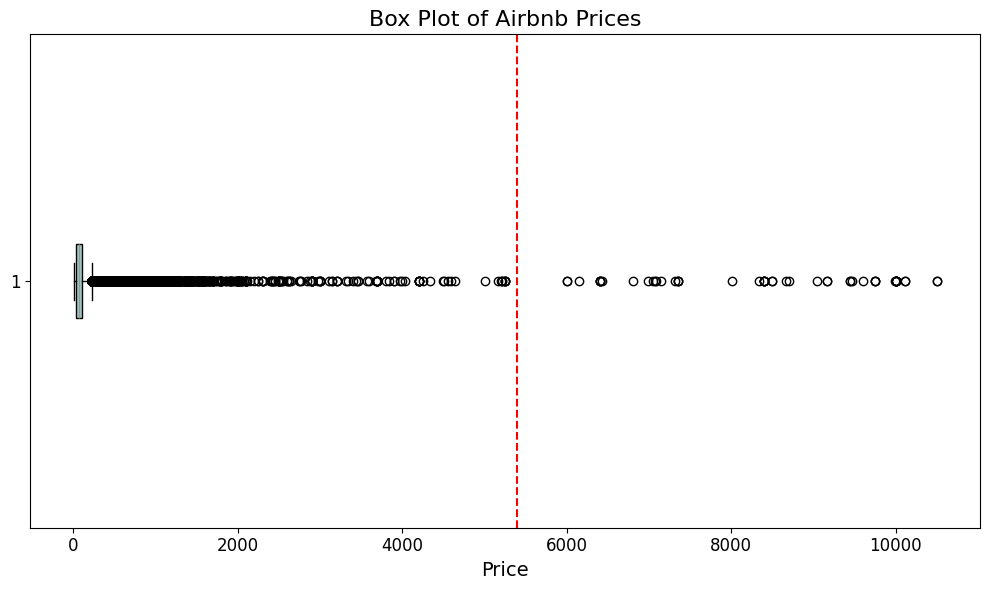

In [ ]:
plt.figure(figsize=(10, 6))
new_df = airbnb_df[airbnb_df['price'] < 11500]
#draw a vertical line at price 5400
plt.axvline(x=5400, color='red', linestyle='--')
plt.boxplot(new_df['price'], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue', color='black'))
plt.title("Box Plot of Airbnb Prices", fontsize=16)
plt.xlabel("Price", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
upper_bound = 5400
print("New upper bound:", upper_bound)
dropped_airbnb_df = airbnb_df[(airbnb_df['price'] >= lower_bound) & (airbnb_df['price'] <= upper_bound)]

removed = airbnb_df.shape[0] - dropped_airbnb_df.shape[0]
# percentage of dataset the outliers account for
print("Percentage of dataset the outliers account for:", ((removed) / airbnb_df.shape[0]) * 100, "%")
print("Total number of outliers removed: ", removed)
print("Percentage of outliers actually removed: ", removed / 12015)

New upper bound: 5400
Percentage of dataset the outliers account for: 0.03508918004317753 %
Total number of outliers removed:  59
Percentage of outliers actually removed:  0.004910528506034124


Here is the final box plot of our updated dataset. In the end, we removed 0.035% of the dataset as outliers, representing approximately 0.5% of the 12,015 outliers identified using the IQR method. These price points fall within the upper 0.5% of outliers and do not significantly impact the integrity of the original dataset, making their removal a reasonable step for cleaner analysis.

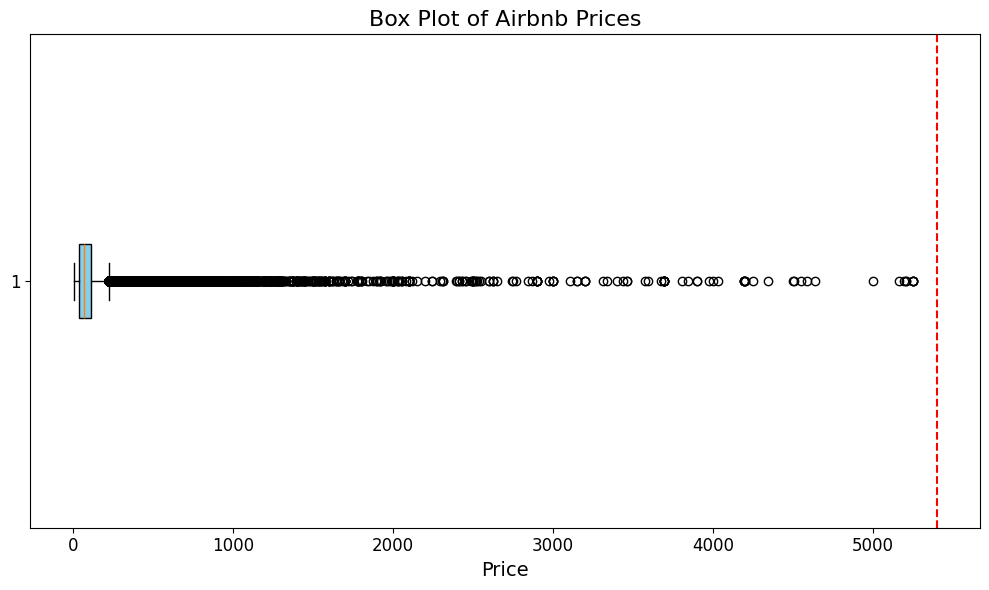

In [ ]:
plt.figure(figsize=(10, 6))
#draw a vertical line at price 5400
plt.axvline(x=5400, color='red', linestyle='--')
plt.boxplot(dropped_airbnb_df['price'], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue', color='black'))
plt.title("Box Plot of Airbnb Prices", fontsize=16)
plt.xlabel("Price", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


Below is a bar graph displaying the Airbnb price distribution for our updated dataset with our new upper bound of \$5400.

Max price: 5250.0


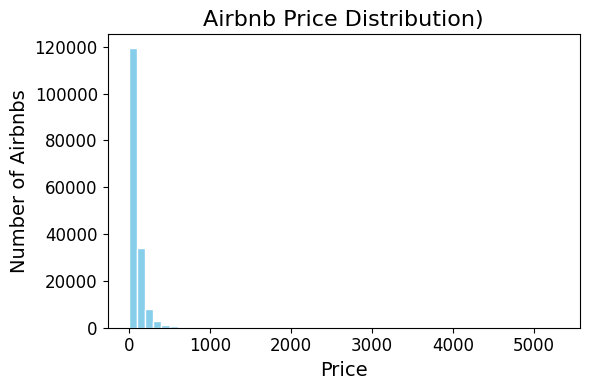

In [ ]:
plt.figure(figsize=(6, 4))
print("Max price: " + str(dropped_airbnb_df['price'].max()))

plt.hist(dropped_airbnb_df['price'], bins=range(0, 5400, 100), color='skyblue', edgecolor='white')
plt.xticks(range(0, 5400, 1000))
plt.title("Airbnb Price Distribution)", fontsize=16)
plt.xlabel("Price", fontsize=14)
plt.ylabel("Number of Airbnbs", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()


We now display the Airbnb price distribution, resized with an upper bound of $300, to more closely examine the distribution of lower, more commonly occurring prices. Note that we did not actually use an upper bound of \$300 for our outlier cutoff since this would result in almost a 4% drop.



Number of listings with price > $300:  6611


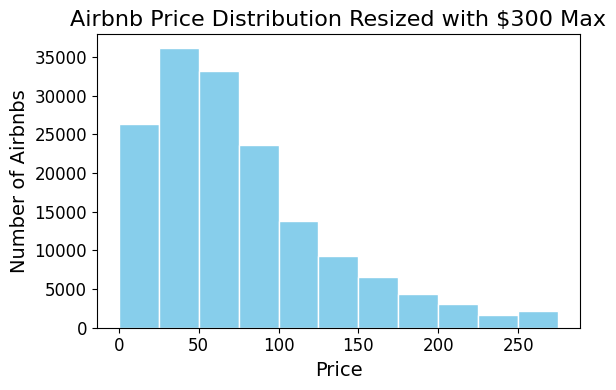

In [ ]:
plt.figure(figsize=(6, 4))
print("Number of listings with price > $300: ", dropped_airbnb_df[dropped_airbnb_df['price'] > 300].shape[0])
plt.hist(dropped_airbnb_df['price'], bins=range(0, 300, 25), color='skyblue', edgecolor='white')
plt.xticks(range(0, 300, 50))
plt.title("Airbnb Price Distribution Resized with $300 Max", fontsize=16)
plt.xlabel("Price", fontsize=14)
plt.ylabel("Number of Airbnbs", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()


We will also display the results in a percentage bar graph to show the most common price buckets. The most common price bucket is \$0 to \$50, with over 37% of the dataset falling into that bucket. The smallest bucket size is \$800 to \$5500 with only 0.52%.

<ipython-input-110-12636fba8647>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped_airbnb_df['price_range'] = pd.cut(


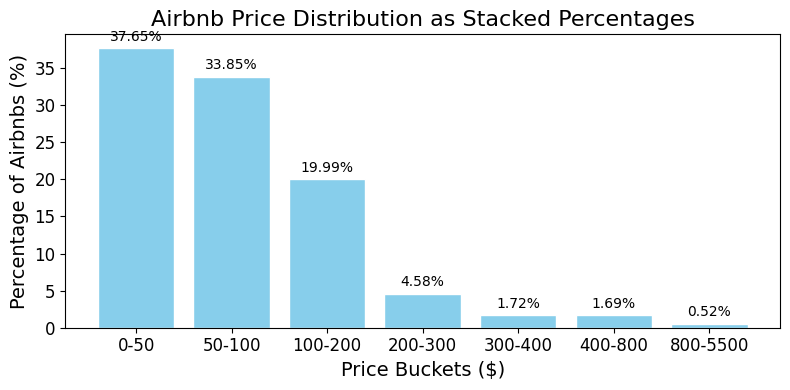

In [ ]:
plt.figure(figsize=(8, 4))

# Define price ranges
bins = [0, 50, 100, 200, 300, 400, 800, 5500]
labels = ['0-50', '50-100', '100-200', '200-300', '300-400', '400-800', '800-5500']

dropped_airbnb_df['price_range'] = pd.cut(
    dropped_airbnb_df['price'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

range_counts = dropped_airbnb_df['price_range'].value_counts(sort=False)

percentages = (range_counts / len(dropped_airbnb_df)) * 100

plt.bar(labels, percentages, color='skyblue', edgecolor='white')

for i, pct in enumerate(percentages):
    plt.text(i, pct + 1, f"{pct:.2f}%", ha='center', fontsize=10)

plt.title("Airbnb Price Distribution as Stacked Percentages", fontsize=16)
plt.xlabel("Price Buckets ($)", fontsize=14)
plt.ylabel("Percentage of Airbnbs (%)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()


Set the Airbnb dataset we work with from now on to be this new dataframe with dropped values


In [ ]:
airbnb_df = dropped_airbnb_df

## 2.3 Preprocessing by Feature

### 2.3.1 Preprocessing by Location

Here, we extract the neighbourhood, city,	local_price,	price, latitude, and longitude from the original `airbnb_df` so we can create models and EDAs that measure the impact of location data on price. This allows us to hone in on one set of features and correlate it specifically to the price.

In [ ]:
#Extracting location related columns from original dataframe.
location_df = airbnb_df[['listing_id', 'neighbourhood', 'city', 'local_price', 'price', 'latitude', 'longitude']]
location_df.dropna()
location_df.head()
print('Max price: ', location_df['price'].max())

Max price:  5250.0


### 2.3.2 Preprocessing by Reviews

Since our `raw_reviews_df` contains listing_id, review_id, and reviewer_id, we create a new `reivew_count_df` to list all the listing_ids with their total review_count. Then, we join `review_count_df` with `airbnb_df` to include the review count by joining on the unique listing_id.


In [ ]:
# Grouping by 'listing_id' and count unique 'review_id' for each 'listing_id'
print('Unique listing_ids: ', raw_reviews_df['listing_id'].nunique())
review_count_df = raw_reviews_df.groupby('listing_id')['review_id'].nunique().reset_index()

# Renaming the 'review_id' column to 'review_count'
review_count_df = review_count_df.rename(columns={'review_id': 'review_count'})


Unique listing_ids:  193556


In [ ]:
#join review_count_df with airbnb_df

merged_airbnb_df = airbnb_df.merge(review_count_df, on='listing_id', how='left')
print('Unique listing_ids: ', merged_airbnb_df['listing_id'].nunique())
print('Size of merged df: ', merged_airbnb_df.shape)


Unique listing_ids:  168084
Size of merged df:  (168084, 15)


Here, we want to include information from the reviews datset that was given on Kaggle since we will try to find a correlation between a host's review score and the price fo the listing, and to clean the dataset we will drop all null values.

In [ ]:
reviews_df = merged_airbnb_df[['listing_id', 'review_scores_rating', 'review_count', 'price', 'city']].copy()
reviews_df.dropna(subset=['review_count'], inplace=True)
reviews_df.dropna(subset=['review_scores_rating'], inplace=True)
reviews_df.dropna(subset=['price'], inplace=True)
print(reviews_df.shape)


print('Min review rating: ', reviews_df['review_scores_rating'].min())
print('Max review rating: ', reviews_df['review_scores_rating'].max())
# print the max pricing
print('Max price: ', reviews_df['price'].max())

(168083, 5)
Min review rating:  20.0
Max review rating:  100.0
Max price:  5250.0


In [ ]:
reviews_df.head()

,listing_id,review_scores_rating,review_count,price,city
0,281420,100.0,2.0,55.65,Paris
1,3705183,100.0,6.0,126.00,Paris
2,4082273,100.0,1.0,93.45,Paris
3,4797344,100.0,1.0,60.90,Paris
4,4823489,100.0,1.0,63.00,Paris


### 2.3.3 Preprocessing by Amenities

Another variable we will consider is the number/type of amenities a given listing has, so we have to include information about this in our dataset.

In [ ]:
#Selecting amenities related columns, retaining city, price and listing_id for EDAs and models
amenities_df = airbnb_df[['listing_id', 'amenities', 'price', 'city']]
amenities_df.head()

,listing_id,amenities,price,city
0,281420,"[""Heating"", ""Kitchen"", ""Washer"", ""Wifi"", ""Long...",55.65,Paris
1,3705183,"[""Shampoo"", ""Heating"", ""Kitchen"", ""Essentials""...",126.00,Paris
2,4082273,"[""Heating"", ""TV"", ""Kitchen"", ""Washer"", ""Wifi"",...",93.45,Paris
3,4797344,"[""Heating"", ""TV"", ""Kitchen"", ""Wifi"", ""Long ter...",60.90,Paris
4,4823489,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Ha...",63.00,Paris


Below, we exploded on amenities so we can more easily extract which amenities each listing had. We converted the dataframe to 1NF so the data only contains atomic values. This reduces redundancy, making the database easier to query and update without ambiguity.


In [ ]:
#explode on amenities by first getting all amentites that a listing has
def parse_amenities(x):
    if isinstance(x, str):
        try:
            return json.loads(x.replace("'", '"'))
        except json.JSONDecodeError:
            return []
    return []

amenities_df = amenities_df.copy()
amenities_df.loc[:, "amenities expanded"] = amenities_df["amenities"].apply(parse_amenities)
amenities_df = amenities_df.explode("amenities expanded")
amenities_df = amenities_df.drop(columns=["amenities"])
amenities_df = amenities_df.reset_index(drop=True)

Below, we identified the top 30 more frequent amenities and defined these to be the 'essential amenities'. Without bounding the number of amenities, there were too many to effectively create meaningful EDAs. Some of the least featured amenities were only used by one airbnb, so we focused only on the top 30 amenities.

In [ ]:
# Identifying the top 30 most frequent amenities
amenity_counts = amenities_df["amenities expanded"].value_counts()
top_amenities = amenity_counts.head(30).index.tolist()
print("Top 30 amenities:")
top_amenities

Top 30 amenities:


['Wifi',
 'Essentials',
 'Kitchen',
 'Long term stays allowed',
 'Hangers',
 'TV',
 'Hair dryer',
 'Iron',
 'Hot water',
 'Dedicated workspace',
 'Heating',
 'Washer',
 'Shampoo',
 'Smoke alarm',
 'Dishes and silverware',
 'Refrigerator',
 'Air conditioning',
 'Cooking basics',
 'Microwave',
 'Bed linens',
 'Stove',
 'Coffee maker',
 'Oven',
 'Elevator',
 'Fire extinguisher',
 'Dryer',
 'First aid kit',
 'Carbon monoxide alarm',
 'Extra pillows and blankets',
 'Free street parking']

In [ ]:
essential_amenities_df = amenities_df.copy()
essential_amenities_df['is_top_amenity'] = essential_amenities_df["amenities expanded"].apply(
    lambda x: x if x in top_amenities else None
)
essential_amenities_df = essential_amenities_df.dropna(subset=['is_top_amenity'])

# Grouping by listing, finding how many of each amenity each listing has
essential_amenities_df = essential_amenities_df.groupby('listing_id').agg({
    'is_top_amenity': lambda x: list(x),
    'amenities expanded': lambda x: list(x),
    'price': 'first',
    'city': 'first'
}).drop(columns=['amenities expanded'])

# Counting number of top amenities for each listing
essential_amenities_df['Number of essentials provided'] = essential_amenities_df['is_top_amenity'].apply(len)
essential_amenities_df = essential_amenities_df.sort_values(by='Number of essentials provided', ascending=True).reset_index()
essential_amenities_df.head()

,listing_id,is_top_amenity,price,city,Number of essentials provided
0,14829686,[Long term stays allowed],128.00,Sydney,1
1,18068497,[Long term stays allowed],37.12,Bangkok,1
2,16134573,[Long term stays allowed],57.80,Rio de Janeiro,1
3,18108590,[Long term stays allowed],46.00,New York,1
4,11025012,[Long term stays allowed],89.05,Hong Kong,1


In [ ]:
#order by number of essentials provided
essential_amenities_df = essential_amenities_df.sort_values(by='Number of essentials provided', ascending=False)
essential_amenities_df

,listing_id,is_top_amenity,price,city,Number of essentials provided
168030,4880542,"[Refrigerator, Microwave, Shampoo, Air conditi...",185.000,New York,30
167890,11824448,"[Washer, Dedicated workspace, Microwave, Fire ...",85.050,Rome,30
167900,38489046,"[Refrigerator, Microwave, Shampoo, Air conditi...",650.000,New York,30
167899,4421694,"[Dryer, Hair dryer, Hot water, Heating, Dedica...",41.635,Cape Town,30
167898,29027131,"[Refrigerator, Microwave, Shampoo, Air conditi...",50.000,New York,30
...,...,...,...,...,...
196,34859211,[Long term stays allowed],117.000,Hong Kong,1
197,5322461,[Long term stays allowed],15.573,Istanbul,1
198,15097085,[Long term stays allowed],55.664,Mexico City,1
199,5858500,[Long term stays allowed],525.000,Rome,1


We expanded the is_top_amenity column into individual rows and applied one-hot encoding to create dummy variables for each top amenity. The resulting new_amenities_df provides a comprehensive dataset for modeling and analysis, with one row per listing and detailed amenity breakdowns.

In [ ]:
# Expanding top amenities into individual rows and creating dummy variables for each amenity (one hot encoding)
new_amenities_df = essential_amenities_df.explode('is_top_amenity')
new_amenities_df = pd.get_dummies(new_amenities_df, columns=['is_top_amenity'])
new_amenities_df.columns = new_amenities_df.columns.str.replace('is_top_amenity_', '')

# Converting cols to integer type & aggregating data by listing_id
columns_to_convert = new_amenities_df.columns.difference(['city'])
new_amenities_df[columns_to_convert] = new_amenities_df[columns_to_convert].astype(int)
new_amenities_df = new_amenities_df.groupby('listing_id').agg({
   **{col: 'sum' for col in new_amenities_df.columns if col not in ['listing_id', 'price', 'Number of essentials provided']},
   'price': 'first',
   'Number of essentials provided': 'first',
   'city': 'first'
}).reset_index()
new_amenities_df.head()

,listing_id,city,Air conditioning,Bed linens,Carbon monoxide alarm,Coffee maker,Cooking basics,Dedicated workspace,Dishes and silverware,Dryer,...,Oven,Refrigerator,Shampoo,Smoke alarm,Stove,TV,Washer,Wifi,price,Number of essentials provided
0,2577,Paris,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,1,1,131,12
1,2737,Rome,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,22,11
2,2903,Rome,1,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,1,38,13
3,3079,Rome,1,1,0,0,0,1,0,1,...,0,0,1,0,0,1,1,1,110,18
4,3191,Cape Town,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,27,25


# Part 3: Exploratory Data Analysis

## 3.1 Feature Correlation Heatmap

Determine which variables are correlated with each other, with careful notice to which variables are the most highly correlated to our target variable: price

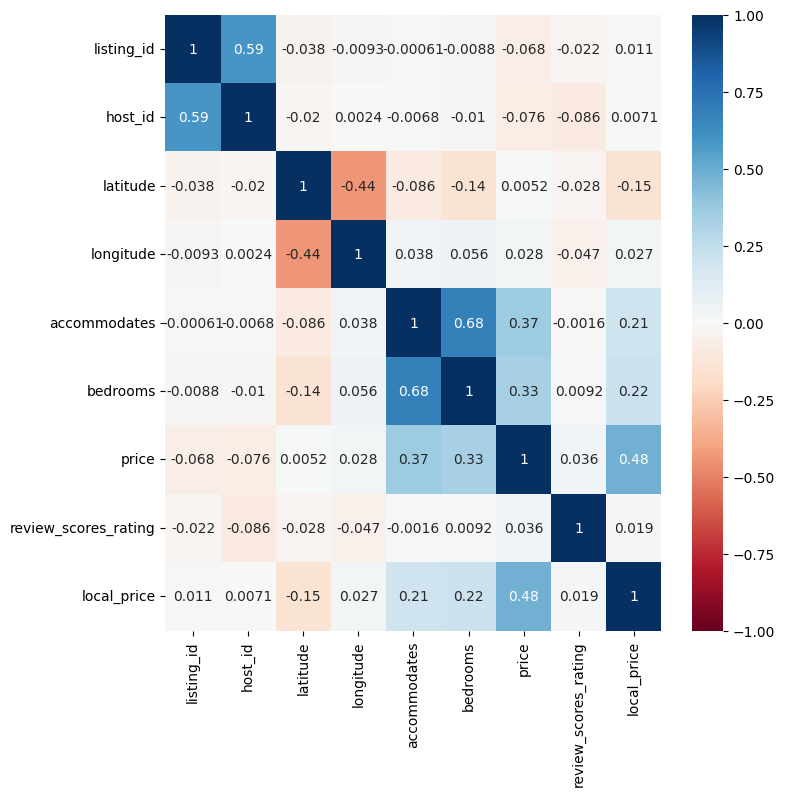

In [ ]:
num_df = airbnb_df.select_dtypes(include=['float64', 'int64'])
num_df.dropna(inplace=True)
plt.figure(figsize = (8,8))
corr_mat = num_df.corr()
sns.heatmap(corr_mat, annot=True, cmap='RdBu', vmin=-1, vmax=1)
plt.show()

Key Takeaways:


*   The biggest correlation between features is bedrooms and accomodates with a correlation coefficient of 0.68, which is to be expected, since the number of bedrooms determines how many guests can stay at each Airbnb.
*   The second most correlated features are price and local price, which also makes sense since we derived the final price from the local price.
*   There is nothing that is very correlated with price, which is the feature we are trying to predict. This may pose a challenge when we attempt to use these features in our models. The most correlated feature, besides local_price, to price is accomodates with a correlation coefficient of 0.26. This is to be expected because it costs more to rent out more bedrooms.



In [ ]:
prices_df = airbnb_df[['listing_id', 'host_id', 'price', 'city', 'local_price']]
prices_df = prices_df.sort_values(by='price', ascending=False)
prices_df.head()

,listing_id,host_id,price,city,local_price
92556,41652684,99715901,5250.000,Paris,5000
127838,38233759,290524109,5250.000,Paris,5000
246704,4867588,9760403,5250.000,Rome,5000
187291,7158673,37489386,5250.000,Paris,5000
147928,14658972,91054410,5206.428,Istanbul,179532


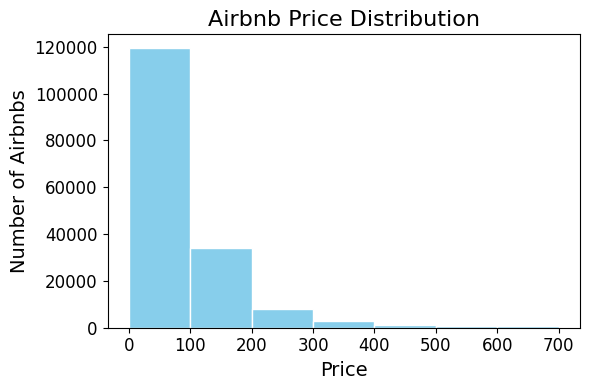

In [ ]:
#graph of the airbnb price distribution in a bar graph with bins of 100 going up to 800
plt.figure(figsize=(6, 4))
plt.hist(prices_df['price'], bins=range(0, 800, 100), color = 'skyblue', edgecolor='white')
plt.xticks(range(0, 800, 100))
plt.title("Airbnb Price Distribution", fontsize=16)
plt.xlabel("Price", fontsize=14)
plt.ylabel("Number of Airbnbs", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Takeaways:


*   Most airbnbs have a price of under 100 dollars, which is to be expected. As the price increases above 200 dollars, the number of airbnbs with each price falls off dramatically.



## 3.2 Locations EDAs


In [ ]:
city_counts = location_df['city'].value_counts()
print("listings per city:", city_counts)

location_df = location_df[location_df['price'] < 100000]

listings per city: city
Paris             37983
New York          24169
Sydney            20840
Rome              20233
Rio de Janeiro    14876
Mexico City       14037
Cape Town         12371
Istanbul          10404
Bangkok           10022
Hong Kong          3149
Name: count, dtype: int64


#### 3.2.1 Airbnb Prices by City

Below is the distribution of listings per city.


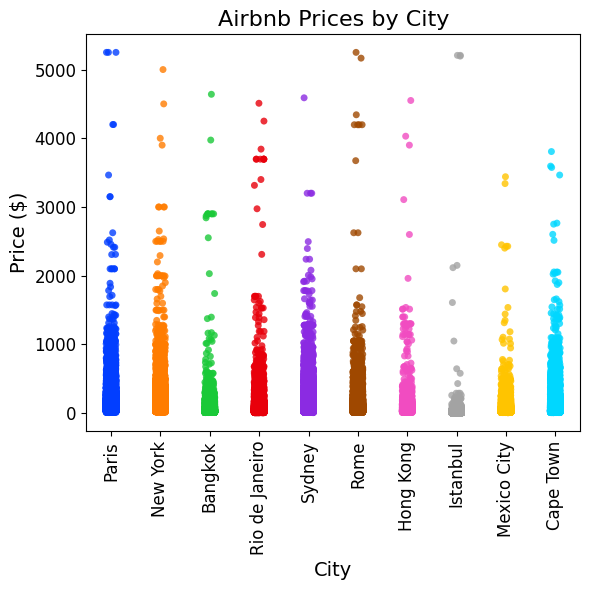

In [ ]:
plt.figure(figsize=(6, 6))
sns.stripplot(data=location_df, x='city', y='price', palette='bright',
              hue = 'city', jitter=True, alpha=0.8)
plt.title('Airbnb Prices by City', fontsize= 16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.xticks(rotation=90)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

Key Takeaways:


*   Most cities share a similar distribution where the majority of listings fall under $1500 when normalized to USD
*   Noteable exceptions are Istanbul and Bangkok which are much less expensive than all other cities. This could be because they have a lower cost-of-living or GDP.



#### 3.2.2 Group Airbnb Listings by Proximity to City Center

In [ ]:
city_centers = {
    'Paris': (48.8566, 2.3522),
    'New York': (40.7128, -74.0060),
    'Bangkok': (13.7563, 100.5018),
    'Rio de Janeiro': (-22.9068, -43.1729),
    'Sydney': (-33.8688, 151.2093),
    'Istanbul': (41.0082, 28.9784),
    'Rome': (41.9028, 12.4964),
    'Hong Kong': (22.3193, 114.1),
    'Cape Town': (-33.9249, 18.4241),
    'Mexico City': (19.4326, -99.1332)
}
#get distance from city center to each airbnb
def calculate_distance(row):
    city_coords = city_centers[row['city']]
    return geodesic((row['latitude'], row['longitude']), city_coords).km

location_df.loc[:, 'distance_to_center'] = location_df.apply(calculate_distance, axis=1)
location_df['within_5km'] = location_df['distance_to_center'].apply(lambda x: 1 if x <= 5 else 0)
location_df.head()

,listing_id,neighbourhood,city,local_price,price,latitude,longitude,distance_to_center,within_5km
0,281420,Buttes-Montmartre,Paris,53,55.65,48.88668,2.33343,3.617431,1
1,3705183,Buttes-Montmartre,Paris,120,126.00,48.88617,2.34515,3.328821,1
2,4082273,Elysee,Paris,89,93.45,48.88112,2.31712,3.749513,1
3,4797344,Vaugirard,Paris,58,60.90,48.84571,2.30584,3.611447,1
4,4823489,Passy,Paris,60,63.00,48.85500,2.26979,6.050093,0


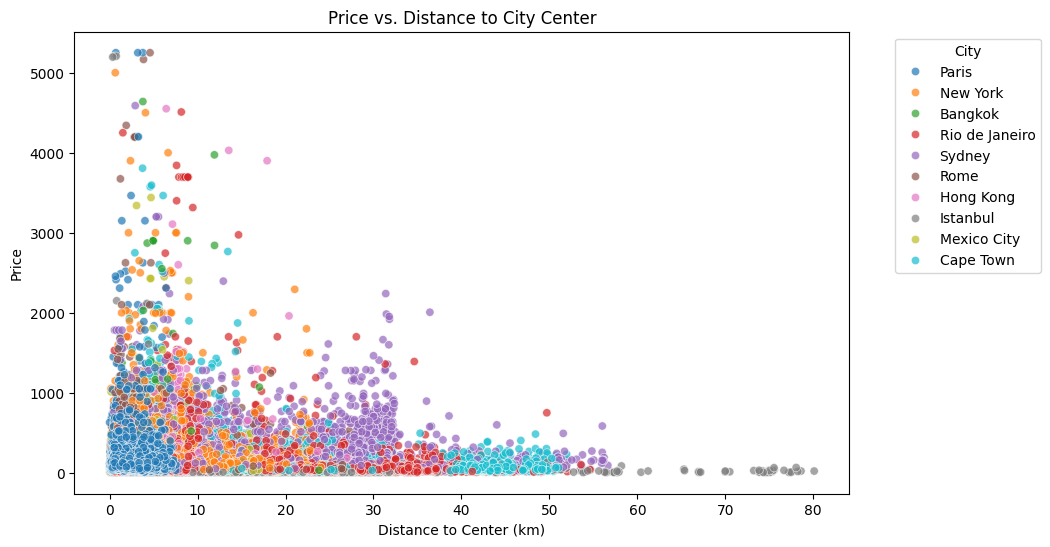

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=location_df, x='distance_to_center', y='price', hue='city', alpha=0.7)
plt.title("Price vs. Distance to City Center")
plt.xlabel("Distance to Center (km)")
plt.ylabel("Price")
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Key Takeaways:


*   Weak negative correlation demonstrated
*   Istanbul's consistent pricing regardless of distance corroborates previous findings
* Other cities don't show as much of a clear trend



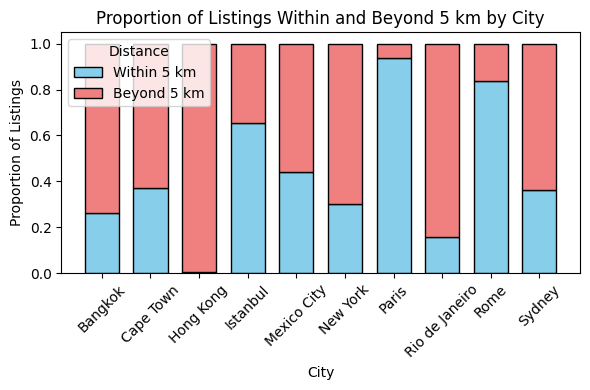

In [ ]:
city_counts = location_df.groupby(['city', 'within_5km']).size().unstack(fill_value=0)
city_proportions = city_counts.div(city_counts.sum(axis=1), axis=0)
plt.figure(figsize=(6, 4))
bar_width = 0.7
cities = city_counts.index
x = np.arange(len(cities))

plt.bar(x, city_proportions[1], label="Within 5 km", color="skyblue", edgecolor="black", width=bar_width)
plt.bar(x, city_proportions[0], label="Beyond 5 km", bottom=city_proportions[1], color="lightcoral", edgecolor="black", width=bar_width)

plt.xticks(x, cities, rotation=45)
plt.ylabel("Proportion of Listings")
plt.xlabel("City")
plt.title("Proportion of Listings Within and Beyond 5 km by City")
plt.legend(title="Distance")
plt.tight_layout()

plt.show()

In [ ]:
#minimum wage of each location in local currency
min_wages = {
    'Paris': 11.65,
    'New York': 16.00,
    'Bangkok': 350.00,
    'Rio de Janeiro': 6.41,
    'Sydney': 24.10,
    'Istanbul': 88.90,
    'Rome': 9.50,
    'Hong Kong': 40.00,
    'Mexico City': 31.12,
    'Cape Town': 27.58
}
location_df['minimum wage'] = location_df['city'].map(min_wages)
#get rough comparison of price relative to area's minimum wage
#(ie. how affordable is the AirBnB for residents of the area)
location_df['price_ratio'] = location_df['local_price'] / location_df['minimum wage']
location_df.head()

,listing_id,neighbourhood,city,local_price,price,latitude,longitude,distance_to_center,within_5km,minimum wage,price_ratio
0,281420,Buttes-Montmartre,Paris,53,55.65,48.88668,2.33343,3.617431,1,11.65,4.549356
1,3705183,Buttes-Montmartre,Paris,120,126.00,48.88617,2.34515,3.328821,1,11.65,10.300429
2,4082273,Elysee,Paris,89,93.45,48.88112,2.31712,3.749513,1,11.65,7.639485
3,4797344,Vaugirard,Paris,58,60.90,48.84571,2.30584,3.611447,1,11.65,4.978541
4,4823489,Passy,Paris,60,63.00,48.85500,2.26979,6.050093,0,11.65,5.150215


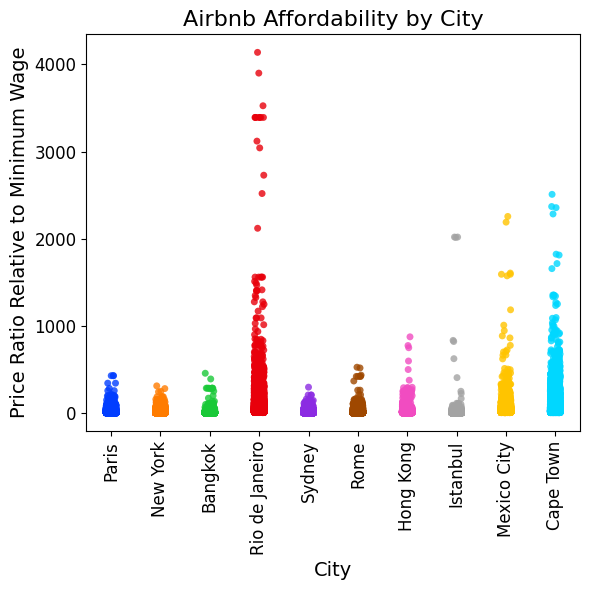

In [ ]:
plt.figure(figsize=(6, 6))
sns.stripplot(data=location_df, x='city', y='price_ratio', palette='bright',
              hue = 'city', jitter=True, alpha=0.8)
plt.title('Airbnb Affordability by City', fontsize= 16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Price Ratio Relative to Minimum Wage', fontsize=14)
plt.xticks(rotation=90)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

Including information about relative affordability for a country's local residents provides context about the economic factors at play in terms of the housing market. Although every country's distribution of prices seemed to be relatively the same, it is clear that in cities like Rio the Airbnbs are much less affordable for a resident there, whereas metropolitan cities in America and Europe have residents who can much more easily afford their surrounding housing options.

## 3.3 Reviews

### 3.3.1 Airbnb Prices by Reviews

The scatterplot below shows the price of Airbnb listings plotted against their review score rating. There is a loose positive correlation between review scores and listing prices; however, the relationship is not linear, as there is considerable variation in prices across all review scores. The highest-priced listings are predominantly found in the 90-100 review score range, while the lowest review scores are mostly associated with lower-priced listings.

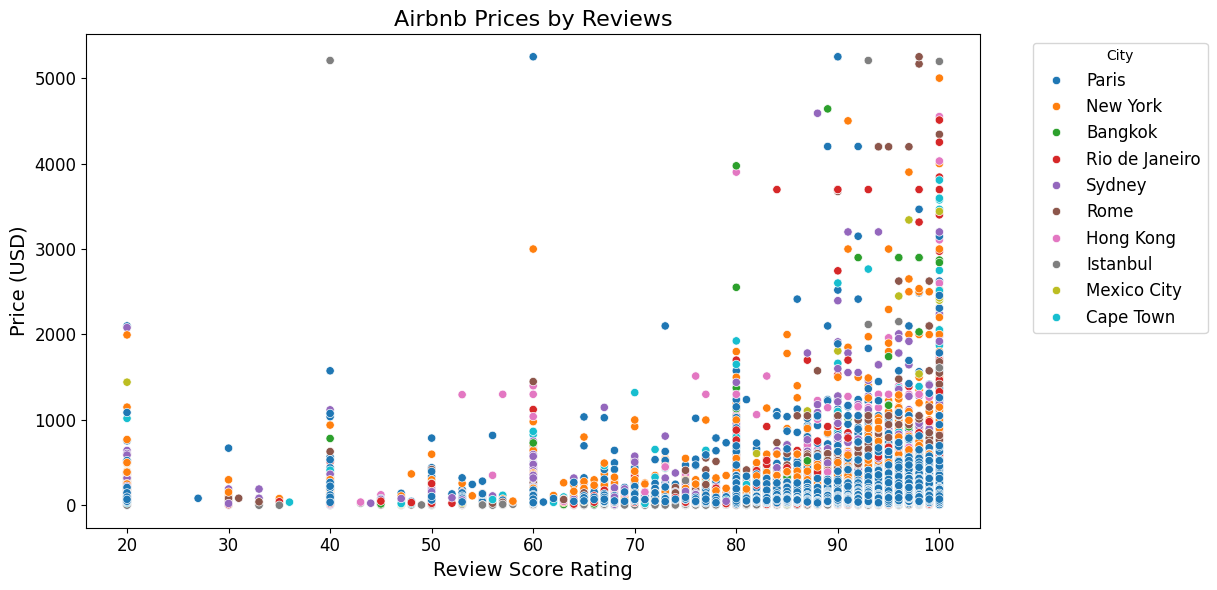

In [ ]:
# plot review on x and price on right with city colored
plt.figure(figsize=(10, 6))
sns.scatterplot(data=reviews_df, x='review_scores_rating', y='price', hue='city')

plt.title("Airbnb Prices by Reviews", fontsize=16)
plt.xlabel("Review Score Rating", fontsize=14)
plt.ylabel("Price (USD)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)


This second scatterplot below examines the relationship between Airbnb listing prices and the total number of reviews received. There is a loose negative correlation between review count and prices, with higher review counts generally associated with lower prices. However, there is again significant variability among listings with low review counts.


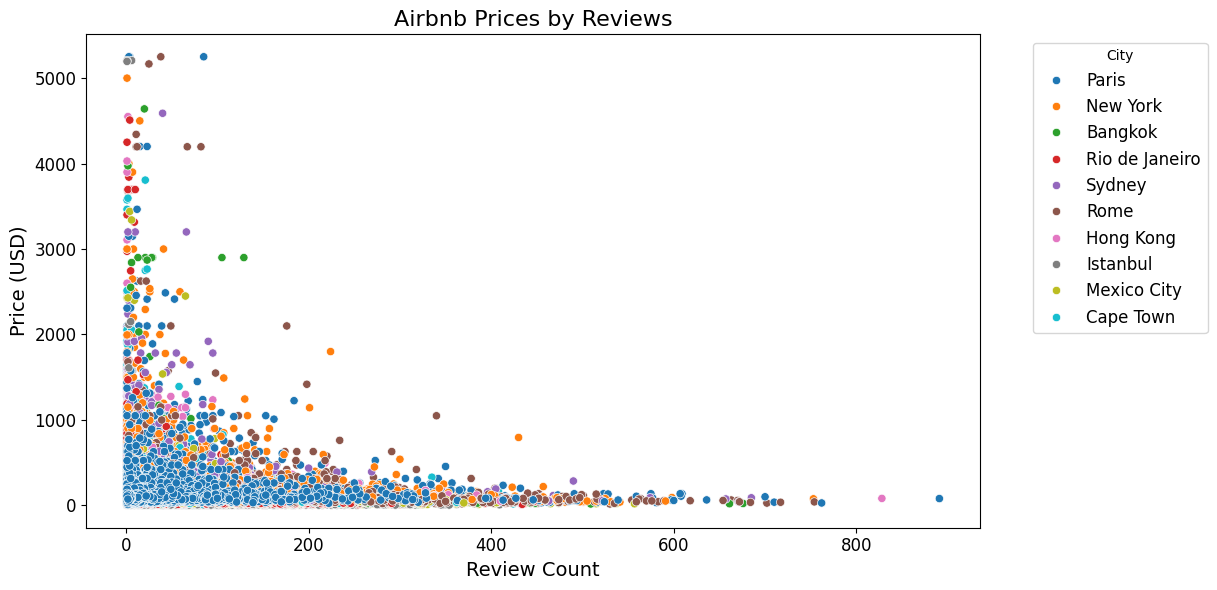

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=reviews_df, x='review_count', y='price', hue='city')

plt.title("Airbnb Prices by Reviews", fontsize=16)
plt.xlabel("Review Count", fontsize=14)
plt.ylabel("Price (USD)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)


## 3.4 Amenities

### 3.4.1 Number of Airbnbs with Each Amenity (Top 30)

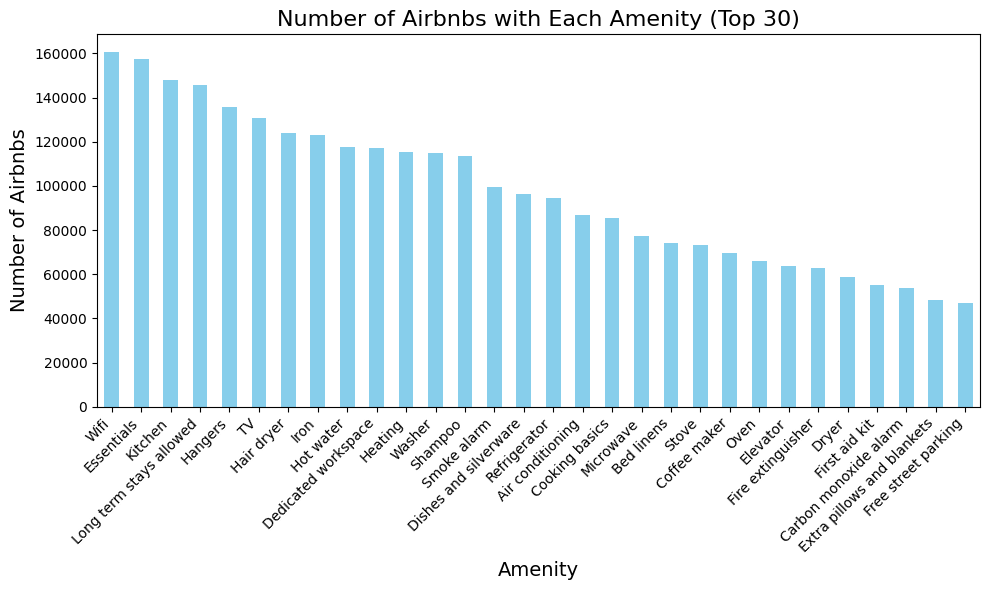

In [ ]:
#graphing the amount of units that have each amenity.
amenity_counts = amenities_df["amenities expanded"].value_counts()
#get the top ten amenities with the most counts
top_amenity_counts = amenity_counts.head(30)
plt.figure(figsize=(10, 6))
top_amenity_counts.plot(kind='bar', color='skyblue')
plt.title("Number of Airbnbs with Each Amenity (Top 30)", fontsize=16)
plt.xlabel("Amenity", fontsize=14)
plt.ylabel("Number of Airbnbs", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Key Takeaways:
<br>We define "essential amenities" to be the top 30 amenities, as graphed above.

*  The most supplied amenity is Wifi with over 250,000 units supplying this amenity, closely followed by essentials (a very vague description) and "long term stays allowed"
*   A lot electronics are featured in the top 20 most provided amenities, probably reflecting customer demand for such items. These items all include amenities that are necessary for living.



### 3.4.2 Airbnbs with Each Count of Essential Amenities

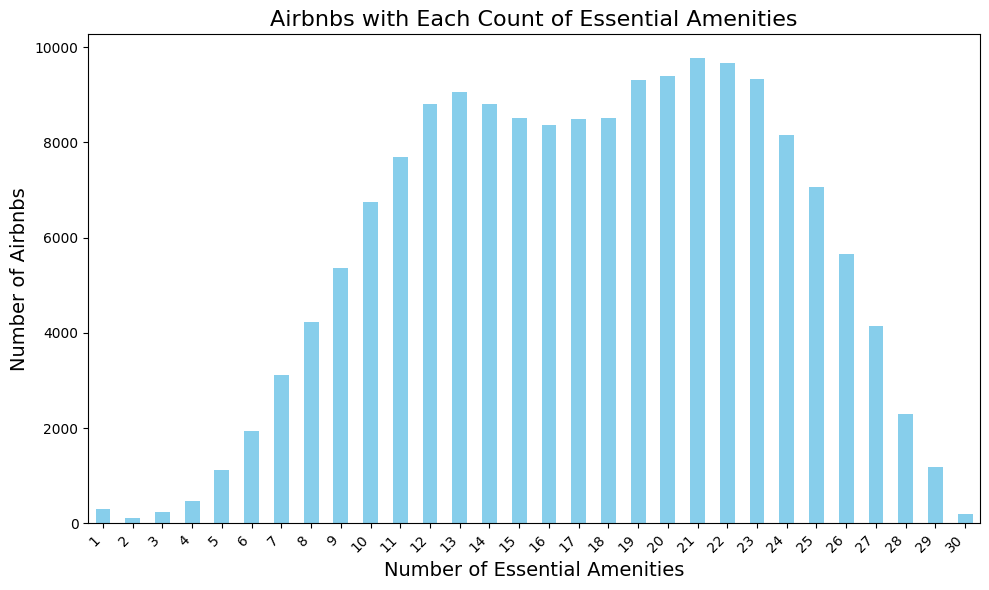

In [ ]:
#graphing number of airbnbs for every number of is_top_amenity on x axis in bar graph
plt.figure(figsize=(10, 6))
counts = essential_amenities_df['Number of essentials provided'].value_counts()
counts = counts.sort_index()
counts.plot(kind='bar', color='skyblue')
plt.title("Airbnbs with Each Count of Essential Amenities", fontsize=16)
plt.xlabel("Number of Essential Amenities", fontsize=14)
plt.ylabel("Number of Airbnbs", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Key takeaways:


*   The distribution looks fairly normal, with most Airbnbs having between 13 and 23 essential amenities.
*   Out of all numbers of essential amenities, the most Airbnbs have 21 out of 30 essential amenities.
*   Very few listings have between 1 and 5 essential amenities and over 28 essential amenities.



### 3.4.3 Price by Number of Essential Amenities

<ipython-input-147-346a1370aa6f>:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


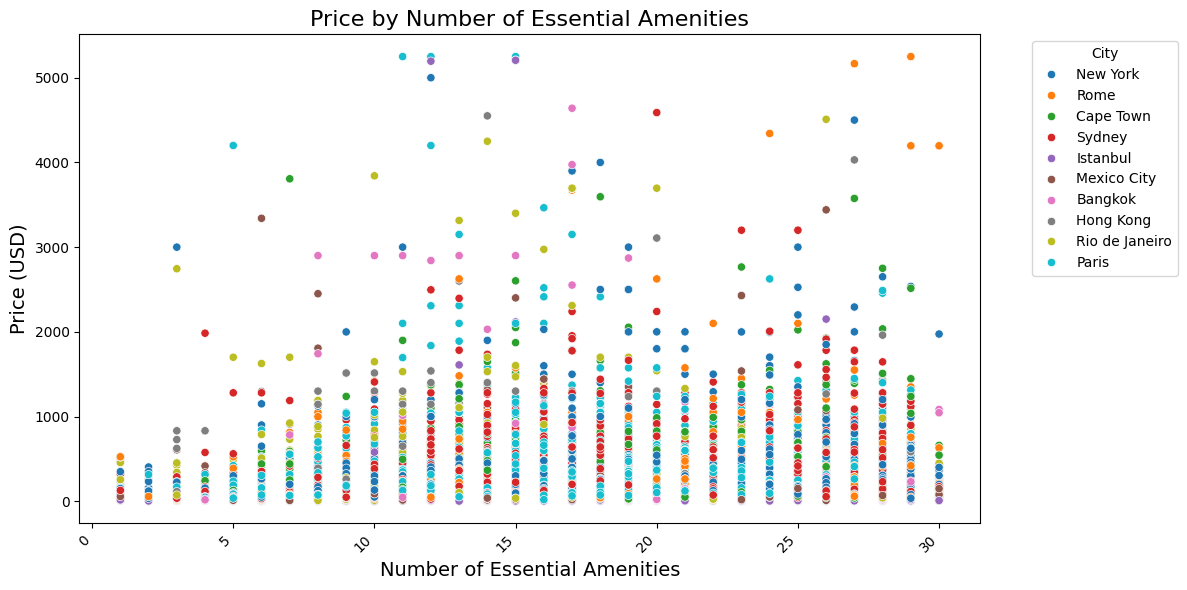

In [ ]:
#plotting number of amenities by prices
plt.figure(figsize=(10, 6))
sns.scatterplot(data=essential_amenities_df, x='Number of essentials provided', y='price', hue = 'city')
plt.title("Price by Number of Essential Amenities", fontsize=16)
plt.xlabel("Number of Essential Amenities", fontsize=14)
plt.ylabel("Price (USD)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="City")
plt.show()

Key Takeaways:

Among lower numbers of essential amenities, it seems like fewer essential amenities results in a lower price (for under 5 essential amenities). However, for higher amounts of essential amenities, the number of amenities doesn't seem to affect the price much. The distribution of points for each city looks the same for each number of essential amenities. This may pose an issue when we try to use a model to predict the price using the number of essential amenities, as there does not seem to be a strong correlation between number of essential amenities and price overall.



### 3.4.4 Price Distribution for Each Essential Amenity

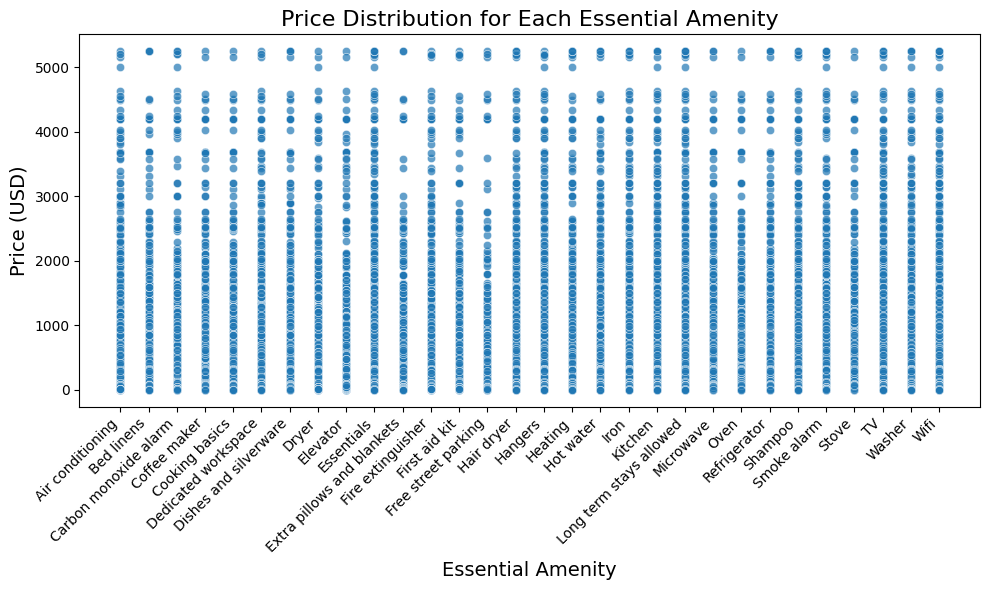

In [ ]:
# Plotting the price distribution for each eseential amenity; one listing can be plotted multiple times.
amenity_prices = new_amenities_df.copy()
amenity_prices = amenity_prices.drop(columns=['city', 'Number of essentials provided'])
amenity_prices = amenity_prices.melt(id_vars='price',
                                       var_name='Amenity',
                                       value_name='Presence')
amenity_prices_present = amenity_prices[amenity_prices['Presence'] == 1]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=amenity_prices_present, x='Amenity', y='price', alpha=0.7)
plt.title("Price Distribution for Each Essential Amenity", fontsize=16)
plt.xlabel("Essential Amenity", fontsize=14)
plt.ylabel("Price (USD)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Key Takeaways:

Each amenity seems to have the around the same prices for each Airbnb listing that contains that amenity. Keep in mind that the same listing can show up multiple times in this scatterplot. This is as expected because in the previous figure, there doesn't seem to be a string correlation between number of amenities and price. This figure demonstrates that there is not a strong correlation between the type of essential amenity and price, making our findings a bit more specific.

# Part 4: Feature Engineering & Preprocessing

## 4.1 Merge Dataframes

We merged all of the relevant dataframes with extra columns to create a comprehensive dataframe with all features we would like to test on to predict price.

In [ ]:
#merge airbnb_df with the reviews, location, and amenities dataframes.
merged_airbnb_df = airbnb_df.merge(essential_amenities_df, on='listing_id', how='inner')
reviews_features = reviews_df[['listing_id', 'review_scores_rating', 'review_count']]
merged_airbnb_df = merged_airbnb_df.drop(columns = 'review_scores_rating')
merged_airbnb_df = merged_airbnb_df.merge(reviews_features, on='listing_id', how='inner')
merged_airbnb_df = merged_airbnb_df.drop(columns = ['amenities', 'is_top_amenity', 'city_y', 'price_x', 'host_location', 'neighbourhood', 'local_price', 'price_range'])
merged_airbnb_df = merged_airbnb_df.rename(columns={'city_x': 'city', 'price_y': 'price'})
merged_airbnb_df = merged_airbnb_df.merge(location_df[['listing_id', 'distance_to_center', 'within_5km']], on='listing_id', how='inner')

merged_airbnb_df.dropna(inplace=True) # dropped ~500 values

merged_airbnb_df.head()

,listing_id,host_id,city,latitude,longitude,accommodates,bedrooms,price,Number of essentials provided,review_scores_rating,review_count,distance_to_center,within_5km
0,281420,1466919,Paris,48.88668,2.33343,2,1.0,55.65,5,100.0,2.0,3.617431,1
1,3705183,10328771,Paris,48.88617,2.34515,2,1.0,126.00,8,100.0,6.0,3.328821,1
2,4082273,19252768,Paris,48.88112,2.31712,2,1.0,93.45,6,100.0,1.0,3.749513,1
3,4797344,10668311,Paris,48.84571,2.30584,2,1.0,60.90,5,100.0,1.0,3.611447,1
4,4823489,24837558,Paris,48.85500,2.26979,2,1.0,63.00,10,100.0,1.0,6.050093,0


## 4.2 Balance Data

In [ ]:
#Checking out the stats for each city.
city_price_stats = merged_airbnb_df.groupby('city')['price'].describe()
print(city_price_stats)

                  count        mean         std     min     25%     50%  \
city                                                                      
Bangkok         10021.0   49.314559  124.439915   7.946  19.720  29.000   
Cape Town       12366.0  106.636585  159.367438   6.710  35.750  58.135   
Hong Kong        3149.0  105.563138  211.470435  10.140  36.400  58.500   
Istanbul        10404.0   13.232198   96.312304   1.160   4.524   7.482   
Mexico City     14032.0   48.428982   83.838914   4.900  19.600  33.810   
New York        24163.0  130.438439  152.467986  10.000  60.000  96.000   
Paris           37967.0  119.968259  129.236106   8.400  63.000  92.400   
Rio de Janeiro  14870.0   68.598293  147.330643   5.610  25.330  41.310   
Rome            20226.0   91.726632  131.719944   9.450  47.250  68.250   
Sydney          20832.0  125.242673  158.628410   7.040  48.000  80.000   

                     75%       max  
city                                
Bangkok          48.2270 



*   Cities like New York, Paris, and Sydney have higher average prices, while Istanbul has the lowest average price but a long tail (max = 5206.428).
*   Hong Kong and Istanbul have the largest spreads, indicating variability within the cities.
*   Extreme maximum values (e.g., Paris = 5250.000, New York = 5000.000) suggest outliers that could influence model predictions and lead to over-reliance on city features.



Want to correct for the imbalance of Istanbul's data, as its long right tail could skew model feature importance later on.

Here, we are balancing the dataset by limiting the maximum number of listings per city to 5000. We are also ensuring each city and price quartile group has a maximum of 1000 listings. This ensures equal representation across cities, reducing potential bias in the model

In [ ]:
# Balancing the dataset by limiting the maximum number of listings per city to 5000
balanced_df = merged_airbnb_df.groupby('city', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 5000), random_state=42)
)

<ipython-input-151-e800732bc26e>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = merged_airbnb_df.groupby('city', group_keys=False).apply(


In [ ]:
# Balancing the dataset by ensuring each city and price quartile group has a maximum of 1000 listings
# If a group has more than 1000 listings, a random sample of 1000 is taken; otherwise, all listings are kept
balanced_df = merged_airbnb_df.groupby(['city', pd.qcut(merged_airbnb_df['price'], 4)]).apply(
    lambda x: x.sample(n=1000, random_state=42, replace=False) if len(x) > 1000 else x
)

<ipython-input-152-99869c7d15d8>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  balanced_df = merged_airbnb_df.groupby(['city', pd.qcut(merged_airbnb_df['price'], 4)]).apply(
<ipython-input-152-99869c7d15d8>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = merged_airbnb_df.groupby(['city', pd.qcut(merged_airbnb_df['price'], 4)]).apply(


In [ ]:
merged_airbnb_df = balanced_df.reset_index(drop=True)
merged_airbnb_df.head()

,listing_id,host_id,city,latitude,longitude,accommodates,bedrooms,price,Number of essentials provided,review_scores_rating,review_count,distance_to_center,within_5km
0,26261513,19266319,Bangkok,13.71012,100.59286,4,2.0,31.494,25,93.0,9.0,11.095191,0
1,29350957,111080848,Bangkok,13.81066,100.66699,2,1.0,10.150,16,89.0,13.0,18.848018,0
2,22168424,158773709,Bangkok,13.80638,100.57269,2,1.0,31.842,21,88.0,16.0,9.458474,0
3,39452927,303037310,Bangkok,13.79105,100.55156,2,1.0,20.300,14,93.0,3.0,6.613346,0
4,35148977,176795569,Bangkok,13.94167,100.61192,2,1.0,20.010,23,100.0,3.0,23.713550,0


## 4.3 Train Test Split

We applied a logarithm transformation to the y price values because our data is right skewed with a lot of low prices and a few very high prices. This helps normalize the distribution of the data and improve model performance.

In [ ]:
#Define X and y to be merged_airbnb without price and only the price column respectively.
X = merged_airbnb_df.drop(columns='price')
y = np.log(merged_airbnb_df['price'])

In [ ]:
# Split the dataset into train and test with an 80-20 split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## 4.4 One Hot Encoder

We chose to use One-Hot Encoding (OHE) for the city feature in Airbnb data in order to ensure that the categorical nature of the data is accurately represented for in our machine learning models. Unlike numerical encoding, which can imply an unintended order or ranking between cities, OHE treats each city as a distinct and independent category by creating separate binary columns. This approach allows the model to assign individual weights to each city, capturing its unique contribution to pricing or other outcomes.

In [ ]:
#split columns into numerical and non-numerical
to_encode = ['city'] # columns that need to encode
not_encode = [col for col in X.columns if col not in to_encode]

In [ ]:
#Instantiate OHE and fit
ohe = OneHotEncoder(sparse_output = False, drop = 'first', handle_unknown='ignore')
X_train_encoded = ohe.fit_transform(X_train[to_encode])
X_test_encoded = ohe.transform(X_test[to_encode])

In [ ]:
#Transform into dataframes and concatenate to already numerical data
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns = ohe.get_feature_names_out(to_encode))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns = ohe.get_feature_names_out(to_encode))
X_train_encoded_full = pd.concat([X_train_encoded_df, pd.DataFrame(X_train[not_encode]).reset_index(drop = True)], axis = 1)
X_test_encoded_full = pd.concat([X_test_encoded_df, pd.DataFrame(X_test[not_encode]).reset_index(drop = True)], axis = 1)

## 4.5 PCA

Using Principle Component Analysis and scaling on our data helps address issues of high dimensionality and varying feature scales. PCA reduces the number of features while preserving most of the variance, simplifying the data and removing redundancy. This ensures features like price, location, and review counts are on a comparable scale, preventing dominance by features with larger ranges. Together, these techniques improve model efficiency, reduce noise, and help prevent overfitting in our future models.

In [ ]:
#scaling
X_train_scaled = X_train_encoded_full.copy(deep = True)
X_test_scaled = X_test_encoded_full.copy(deep = True)

In [ ]:
#instantiate standard scalar and fit
ss = StandardScaler()
X_train_scaled[not_encode] = ss.fit_transform(X_train_scaled[not_encode])
X_test_scaled[not_encode] = ss.transform(X_test_scaled[not_encode])
X_train_scaled.head()

,city_Cape Town,city_Hong Kong,city_Istanbul,city_Mexico City,city_New York,city_Paris,city_Rio de Janeiro,city_Rome,city_Sydney,listing_id,host_id,latitude,longitude,accommodates,bedrooms,Number of essentials provided,review_scores_rating,review_count,distance_to_center,within_5km
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.311072,-0.894693,1.184978,-0.196578,-0.658928,-0.539145,-1.198770,-0.035730,-0.508181,-0.724796,1.184593
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.587210,0.319708,0.251722,-1.473389,0.141037,0.362085,-1.031036,0.641964,-0.547917,-0.015373,-0.844172
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.571832,1.040844,0.963802,-0.069304,-0.658928,-0.539145,-1.031036,-2.552880,-0.448578,-0.892436,1.184593
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.364934,-0.918259,0.963387,-0.069434,0.141037,-0.539145,0.981772,0.448337,-0.110826,-0.714106,1.184593
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.225398,0.535941,0.072752,1.037748,-0.258946,-0.539145,-0.024632,0.351523,0.187191,-0.301580,-0.844172


# Part 5: Modeling

## 5.1 Baseline Models: Linear Regression

We ran baseline linear regression models on location, reviews, and amenities. We chose linear regression because it allowed us to evaluate relationships directly between features and price.

### 5.1.1 Baseline Model: Location (Latitude/Longitude and City)

In [ ]:
X = location_df[['listing_id', 'latitude', 'longitude', 'price']]
city_dummies = pd.get_dummies(location_df[['listing_id', 'city']], columns=['city'], drop_first=True)

X_combined = pd.merge(X, city_dummies, on='listing_id', how='inner')

X_combined = X_combined.drop(columns=['listing_id'])
X_combined = X_combined.dropna()

y = X_combined['price']
X_combined = X_combined.drop(columns=['price'])

In [ ]:
model = LinearRegression()
model.fit(X_combined, y)

slope = model.coef_[0]
intercept = model.intercept_
print(f"price = {slope} * location + {intercept}")

r_squared = model.score(X_combined, y)
print(f"R² score: {r_squared}")

price = 106.81099923703711 * location + 3664.4555859196316
R² score: 0.062304150103580924


### 5.1.2 Baseline Model: Reviews



In [ ]:
X = reviews_df[['review_scores_rating', 'review_count']]
# R^2: R² score: 0.0020872841511384577
y = reviews_df['price']

model = LinearRegression()
model.fit(X, y)

slope = model.coef_[0]
intercept = model.intercept_
print(f"price = {slope} * reviews + {intercept}")

r_squared = model.score(X, y)
print(f"R² score: {r_squared}")

price = 0.538671438838804 * reviews + 48.119593786910634
R² score: 0.0020872841511384577


### 5.1.3 Baseline Model: Amenities

In [ ]:
X = essential_amenities_df[['Number of essentials provided']]
y = essential_amenities_df['price']
model = LinearRegression()
model.fit(X, y)

slope = model.coef_[0]
intercept = model.intercept_
print(f"price = {slope} * Number of essentials provided + {intercept}")

r_squared = model.score(X, y)
print(f"R² score: {r_squared}")
# R² score: 0.010196952543196636


price = 2.455147271439262 * Number of essentials provided + 53.53714372731303
R² score: 0.010196952543196636


Key Takeaways:


*   $R^2$ for location: 0.062304150103580924
*   $R^2$  for reviews: 0.0020872841511384577
*   $R^2$ for amenities: 0.010196952543196636

The best Linear Regression baseline model was using location as a feature, with an $R^2$ score of 0.06, which represents extremely low correlation. However, this model provides a good baseline for us to continue improving our models off of.

### 5.1.4 Hypothesis Testing: Amenities

Null Hypothesis: Amenities provided have no significant impact on Airbnb listing prices

Alternative Hypothesis: Amenities provided have a significant impact on Airbnb listing prices

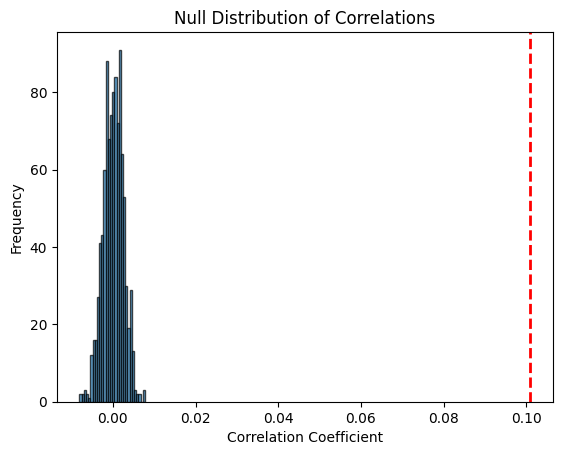

Observed Correlation: 0.1009799610972223
P-value: 0.000999000999000999


In [ ]:
original_data = essential_amenities_df[['Number of essentials provided', 'price']]
observed_correlation = original_data.corr().iloc[0, 1]
num_permutations = 1000
null_distributions = []
for _ in range(num_permutations):
    shuffled_prices = np.random.permutation(original_data['price'])
    shuffled_correlation = np.corrcoef(original_data['Number of essentials provided'], shuffled_prices)[0, 1]
    null_distributions.append(shuffled_correlation)

# calculate p-value
null_distributions = np.array(null_distributions)
p_value = (np.sum(np.abs(null_distributions) >= np.abs(observed_correlation)) + 1) / (num_permutations + 1)

plt.hist(null_distributions, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(observed_correlation, color='red', linestyle='dashed', linewidth=2)
plt.title("Null Distribution of Correlations")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Frequency")
plt.show()

print(f"Observed Correlation: {observed_correlation}")
print(f"P-value: {p_value}")


The p-value represents that assuming the null hypothesis, there is a 0.1 percent change of observing an equal or stronger effect than the actual correlation coefficient. The p-value does not represent exactly what we might get if we were to calculate it mathematically because we are merely simulating the null hypothesis, which could have random divergence. We should reject the null hypothesis because the p-value is 0.001, lower than 0.05.

## 5.2 Random Forest Results

Next, we chose to use a Random Forest model because this model is better at prediction when the data is very noisy, and the features are not as correlated, which describes our dataset at the moment.

### 5.2.1 Random Forest Model

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error: 0.31
Root Mean Squared Error: 0.56
R^2 Score: 0.6087


### 5.2.2 Hyperparameter Tuning

Grid Search:


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.utils import shuffle

SEED = 42
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

rf_model = RandomForestRegressor(random_state=SEED)

param_grid = {
    'n_estimators': [50, 100, 120],
    'max_depth': [5, 10, 20]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train_scaled, y_train)
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .......................max_depth=5, n_estimators=50; total time=   4.1s
[CV] END .......................max_depth=5, n_estimators=50; total time=   5.2s
[CV] END .......................max_depth=5, n_estimators=50; total time=   4.4s
[CV] END .......................max_depth=5, n_estimators=50; total time=   4.7s
[CV] END .......................max_depth=5, n_estimators=50; total time=   4.6s
[CV] END ......................max_depth=5, n_estimators=100; total time=   9.0s
[CV] END ......................max_depth=5, n_estimators=100; total time=   8.6s
[CV] END ......................max_depth=5, n_estimators=100; total time=   8.7s
[CV] END ......................max_depth=5, n_estimators=100; total time=   8.8s
[CV] END ......................max_depth=5, n_estimators=100; total time=   8.5s
[CV] END ......................max_depth=5, n_estimators=120; total time=  11.4s
[CV] END ......................max_depth=5, n_est

In [ ]:
print(f"R² with hyperparameter tuning: {r2:.4f}")

R² with hyperparameter tuning: 0.6074


This represents a slight decrease in $R^2$, but on other iterations of the parameters, it has been as high as 0.6094

Random Search:

In [ ]:
SEED = 42
cv = KFold(n_splits=3, shuffle=True, random_state=SEED)
rf_model = RandomForestRegressor(random_state=SEED)

param_dist = {
    'n_estimators': [50, 100, 120],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=SEED,
)

random_search.fit(X_train_scaled, y_train)
best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
print(f"R² with hyperparameter tuning: {r2:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, n_estimators=100; total time=  19.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, n_estimators=100; total time=  20.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, n_estimators=100; total time=  18.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, n_estimators=100; total time=  29.9s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, n_estimators=100; total time=  27.9s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, n_estimators=100; total time=  24.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, n_estimators=50; total time=  14.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, n_estimators=50; total time=   9.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, n_estimators=50; total time=   9.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=5

By randomizing the search, we can get an $R^2$ value of 0.6104, which is an improvement from our baseline Random Forest model.

### 5.2.3 Feature Importance

<ipython-input-183-2bb98dc1be7c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


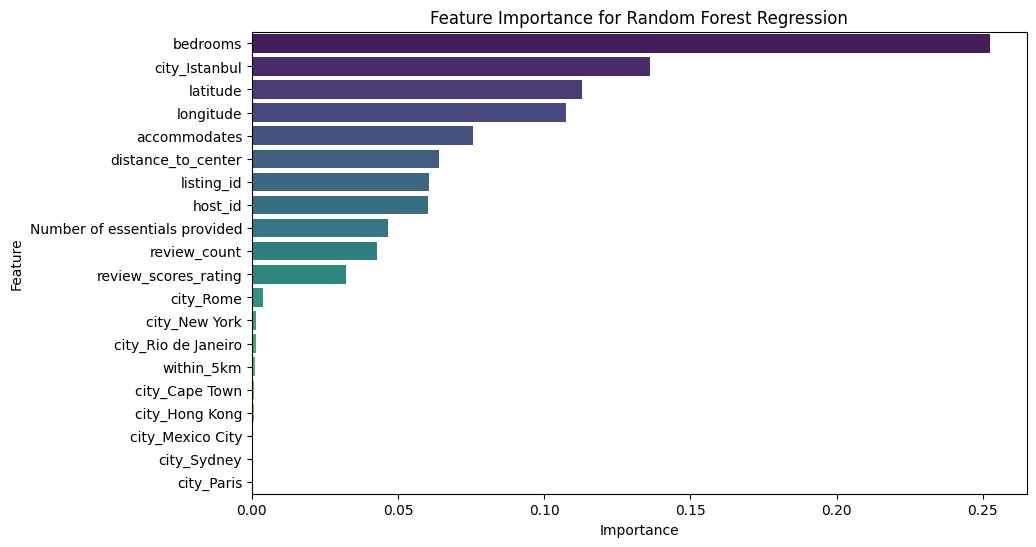

In [ ]:
feature_importances = best_rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    palette='viridis'
)

plt.title('Feature Importance for Random Forest Regression')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.show()

It seems like the second most important feature is cityIstanbul, which just encodes whether or not the Airbnb is in Istanbul. This is likely due to the fact that its prices are so much cheaper than any other location, so being in Istanbul means that it is easier to predict the price.

However, this over-reliance on a single variable where other equivalent variables are not as greatly considered limits generalizability and under-utilizes other features like amenities or reviews.

Note that in previous iterations of running this model, cityIstanbul has shown up as the single most important feature with an importance coefficient above 0.5.

## 5.3 Multiple Linear Regression Results


The next model we decided to use was Multiple Linear Regression (MLR) on the different features of location, review score rating, review count, and number of essential amenities.


### 5.3.1 MLR Model

In [ ]:
X = location_df[['listing_id', 'latitude', 'longitude', 'price']]
city_dummies = pd.get_dummies(location_df[['listing_id', 'city']], columns=['city'], drop_first=True)
location_features = pd.merge(X, city_dummies, on='listing_id', how='inner')

reviews_features = reviews_df[['listing_id', 'review_scores_rating', 'review_count']]

amenities_features = essential_amenities_df[['listing_id','Number of essentials provided']]

X_combined = pd.merge(location_features, reviews_features, on='listing_id', how='inner')
X_combined = pd.merge(X_combined, amenities_features, on='listing_id', how='inner')
y = X_combined['price']
X_combined = X_combined.drop(columns = 'price')
X_combined = X_combined.dropna()
y = y[X_combined.index]

In [ ]:
model = LinearRegression()
model.fit(X_combined, y)

print(f"Price = {model.intercept_} + " + " + ".join([f"{coef} * {feature}" for coef, feature in zip(model.coef_, X_combined.columns)]))

r_squared = model.score(X_combined, y)
print(f"R² score: {r_squared}")

# Create a DataFrame with the feature names and coefficients
coefficients_df = pd.DataFrame({
    'feature': X_combined.columns,  # Get the column names from X_combined
    'coefficient': model.coef_      # Get the coefficients from the model
})

# Print the coefficients
print(coefficients_df)


Price = 2945.785537340053 + -6.785647584637821e-07 * listing_id + 107.32136692923258 * latitude + -43.99505492783307 * longitude + 1559.2936564762126 * city_Cape Town + -257.38792035971795 * city_Hong Kong + -6114.423651833201 * city_Istanbul + -9393.75971778863 * city_Mexico City + -10498.563866551902 * city_New York + -8020.711808429705 * city_Paris + -2368.549492806071 * city_Rio de Janeiro + -6856.656085937473 * city_Rome + 7407.480617798759 * city_Sydney + 0.28989545995798305 * review_scores_rating + -0.22841299042153196 * review_count + 2.931806141691649 * Number of essentials provided
R² score: 0.07944108164436614
                          feature   coefficient
0                      listing_id -6.785648e-07
1                        latitude  1.073214e+02
2                       longitude -4.399505e+01
3                  city_Cape Town  1.559294e+03
4                  city_Hong Kong -2.573879e+02
5                   city_Istanbul -6.114424e+03
6                city_Mexico City -

### 5.3.2 Logarithm Transformation

It is expected that Multiple Linear Regression would yield a lower $R^2$ score of 0.079, given the presence of large outliers. To address this, we will apply a logarithmic transformation to the price variable. This transformation is particularly useful because we have several large outliers in our prices. Recall that we only removed 0.5% of the 12,015 identified outliers in order to retain more data points in our dataset. The log transformation is beneficial in this case because our data is heavily right-skewed, with numerous large outliers, and this transformation compresses the range.

In [ ]:
y = np.log(y)
y = y[X_combined.index]

model = LinearRegression()
model.fit(X_combined, y)

print(f"Price (log-transformed) = {model.intercept_} + " + " + ".join([f"{coef} * {feature}" for coef, feature in zip(model.coef_, X_combined.columns)]))

# Calculate R² score
r_squared = model.score(X_combined, y)
print(f"R² score: {r_squared}")

# Create a DataFrame with the feature names and coefficients
coefficients_df = pd.DataFrame({
    'feature': X_combined.columns,  # Get the column names from X_combined
    'coefficient': model.coef_      # Get the coefficients from the model
})

# Print the coefficients
print(coefficients_df)


Price (log-transformed) = 47.086649508099 + -6.460444913816493e-09 * listing_id + 0.3956142350455822 * latitude + -0.4929257824156926 * longitude + -20.93401586128699 * city_Cape Town + 4.0609903786958395 * city_Hong Kong + -47.51210535988019 * city_Istanbul + -100.62761402113394 * city_Mexico City + -95.6472480264705 * city_New York + -61.23857266247539 * city_Paris + -56.077993487105324 * city_Rio de Janeiro + -53.83075148742153 * city_Rome + 44.70970270890609 * city_Sydney + 0.0029622019615980193 * review_scores_rating + -0.0016051865227827422 * review_count + 0.0275193794783561 * Number of essentials provided
R² score: 0.47227877704521315
                          feature   coefficient
0                      listing_id -6.460445e-09
1                        latitude  3.956142e-01
2                       longitude -4.929258e-01
3                  city_Cape Town -2.093402e+01
4                  city_Hong Kong  4.060990e+00
5                   city_Istanbul -4.751211e+01
6            

With the log-transformation, we have reached an $R^2$ value of 0.473, which means that about 47% of the variance in $\log($price) can be explained by our model.

The coefficient for review_scores_rating is positive (+0.00296), meaning for every 1 point increase in review score, the log-transformed price increases by \$0.00296.

The coefficient for review_count is negative (-0.0016), suggesting that as the number of reviews increases, the price tends to decrease slightly.

The coefficient for number of essentials provided is positive (+0.0275), indicating that listings with more essentials provided (like towels, toiletries, etc.) are slightly more expensive.

Since our MLR model is predicting the log-transformed price, the calculated coefficients reflect relative changes in the price, not absolute ones. A small coefficient, like 0.00296 for review_scores_rating, represents a small percentage increase in the price for higher review scores, but over large numbers of listings, these small changes can add up and contribute to explaining the overall variation in price.

### 5.3.3 Hypothesis Testing

Null Hypothesis: The MLR model’s performance as measured by $R^2$ value is not better than random chance.

Alternative Hypothesis: The MLR model’s performance as measured by $R^2$ value is better than random chance.

We set the significance level to be 0.05.


In [ ]:
#permutation testing
model = LinearRegression()
model.fit(X_combined, y)
original_r2 = model.score(X_combined, y)
print(f"Original R²: {original_r2:.4f}")

n_permutations = 500
simulated_r2 = []

for _ in range(n_permutations):
    y_shuffled = np.random.permutation(y)
    permuted_model = LinearRegression()
    permuted_model.fit(X_combined, y_shuffled)
    permuted_r2 = permuted_model.score(X_combined, y)
    simulated_r2.append(permuted_r2)
p_value = np.mean(np.array(simulated_r2) >= original_r2)
print(f"p-value: {p_value:.4f}")

Original R²: 0.4723
p-value: 0.0000


Because the p-value = 0 < significance level of 0.05, we reject the null hypothesis. This means that the model's performance is statistically significant and not due to random chance.

The permutation test results, shown in the graph below, illustrate the distribution of $R^2$ values generated under the null hypothesis. The original model's $R^2$ (marked by the red dashed line) lies far beyond the $R^2$ score for all simulations in the null world, supporting the conclusion that the observed performance is unlikely due to random chance.

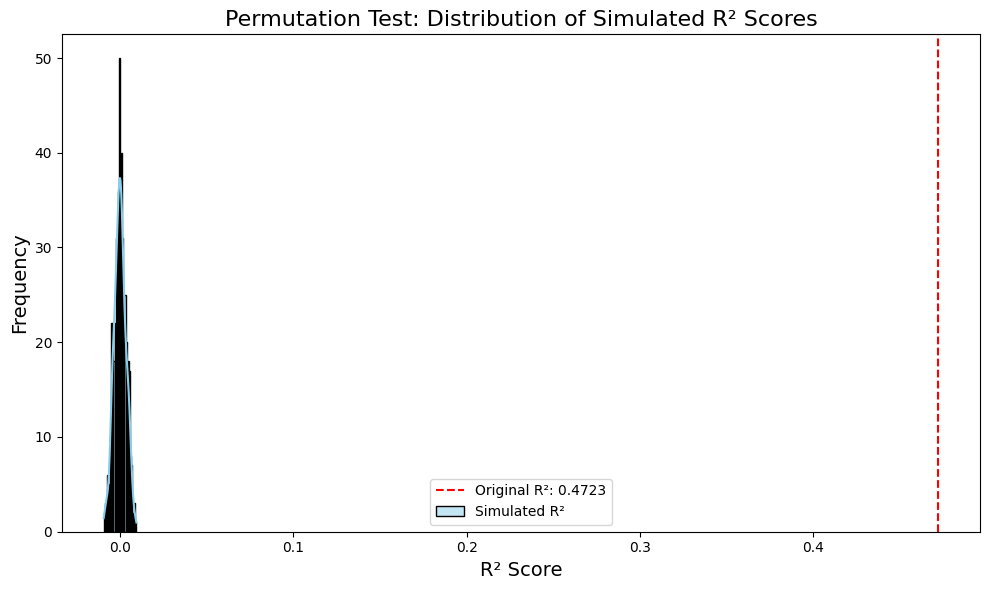

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(simulated_r2, kde=True, color='skyblue', label='Simulated R²', bins=30)
plt.axvline(original_r2, color='red', linestyle='--', label=f'Original R²: {original_r2:.4f}')
plt.title('Permutation Test: Distribution of Simulated R² Scores', fontsize=16)
plt.xlabel('R² Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

### 5.3.4 Bootstrapping

In [ ]:
#bootstrapping
n_bootstraps = 500
bootstrap_r2 = []

for _ in range(n_bootstraps):
    resample_indices = np.random.choice(len(X_combined), size=len(X_combined), replace=True)
    X_resample = X_combined.iloc[resample_indices]
    y_resample = y.iloc[resample_indices]
    bootstrap_model = LinearRegression()
    bootstrap_model.fit(X_resample, y_resample)
    r2 = bootstrap_model.score(X_resample, y_resample)
    bootstrap_r2.append(r2)

bootstrap_mean_r2 = np.mean(bootstrap_r2)
bootstrap_ci_lower = np.percentile(bootstrap_r2, 2.5)
bootstrap_ci_upper = np.percentile(bootstrap_r2, 97.5)

print(f"Bootstrap Mean R²: {bootstrap_mean_r2:.4f}")
print(f"95% Confidence Interval for R²: [{bootstrap_ci_lower:.4f}, {bootstrap_ci_upper:.4f}]")

Bootstrap Mean R²: 0.4724
95% Confidence Interval for R²: [0.4680, 0.4764]


Applying bootstrapping to estimate the confidence interval for the $R^2$ value shows a very narrow interval for 95% confidence, indicating that the model's performance is very reliable and stable. Note that since this a randomized model, different iterations may produce slightly varying confidence intervals.

In summary, the above tests demonstrate that the MLR model has meaningful predictive power and is not driven by randomness.


## 5.4 XGBoost Results

We implemented an XGBoost model due to its ability to handle nonlinear relationships and complex feature interactions, such as those between location, amenities, and pricing. Unlike linear regression, which assumes linearity, XGBoost effectively models nonlinearity and interactions. It is also faster and more memory-efficient than random forest, especially for large datasets, while offering built-in regularization (L1/L2) to reduce overfitting. Additionally, XGBoost handles missing values natively and provides interpretable feature importance scores, making it ideal for understanding the key drivers of price variation.

### 5.4.1 XGBoost Model

In [ ]:
#Extracting columns that are not city (latitude longitude)
non_city_columns = [
    'listing_id', 'host_id', 'latitude', 'longitude', 'accommodates', 'bedrooms',
    'Number of essentials provided', 'review_scores_rating', 'review_count',
    'distance_to_center', 'within_5km'
]
X_train_non_city = X_train_scaled[non_city_columns]
X_test_non_city = X_test_scaled[non_city_columns]

The XGBoost model over-relied on city_Istanbul, so we removed cities from the dataset, which allowed us to increase the depth of the model to account for underfitting

In [ ]:
#Instanstiate XGBoost model with depth of 6 and 100 estimators. Also reg_alpha and reg_lambda to reduce overfitting.
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, reg_alpha=10,
    reg_lambda=10, max_depth=6, random_state=42 )
xgb_model.fit(X_train_non_city, y_train)
y_pred = xgb_model.predict(X_test_non_city)
#evaluate model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 0.57
R²: 0.59


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The baseline model has an $R^2$ value of 0.53 and an RMSE of 0.61. This model is already performing better than the original linear regression baseline models.

Key Takeaways


*  After applying the log transformation to our prices to account for the right skew of the data, the XGBoost model was relying too heavily on city_Istanbul to predict high prices. The log transformation on exacerbated its skewed distribution
*  Originally, max_depth was set to 6, but the that model was relying on city_Istanbul too much with a feature importance coefficient of above 0.9. As such, we reduced max_depth to 3 to prevent overfitting. Now the coefficient for city_Istanbul is below 0.3.



### 5.4.2 Feature Importance

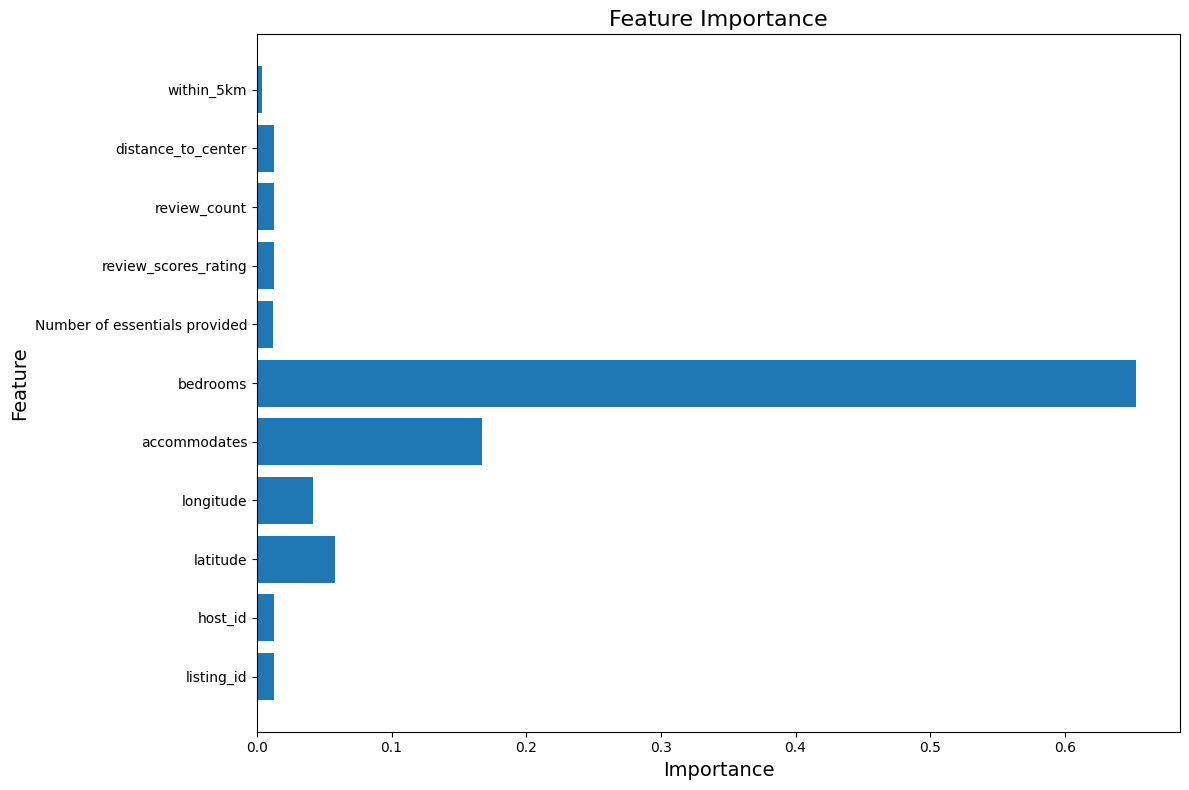

In [ ]:
# Plot the feature importance
plt.figure(figsize=(12, 8))
plt.barh(X_train_non_city.columns, xgb_model.feature_importances_)
plt.title("Feature Importance", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

Key Takeaways


*   Bedrooms were the top feature, as more bedrooms increase maintenance costs and prices.
* This highlights the importance of property characteristics over location, price variation better explained by listing-specific factors.
* An $R^2$ of 0.59 indicates unmeasured factors like seasonality or host reputation also affect prices.
* Implications for hosts: Highlighting features like bedrooms and capacity can attract more bookings.



### 5.4.3 Hyperparameter Tuning

In [ ]:
#Define parameter grid with max_depth range 10 to 15 because model seemed underfitted
#when we manually entered different max_depths initially
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [10, 15],
    "learning_rate": [0.1, 0.2],
    "random_state": [42]
}

#Instantiate XGBoost model
xgboost_model = XGBRegressor(tree_method='hist')

#Define grid search parameters
grid_search = GridSearchCV(
    xgboost_model,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=True,
    n_jobs=-1
)

#Fit the grid search model
grid_search.fit(X_train_non_city, y_train)

print("Best Parameters:", grid_search.best_params_)

#Save the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_non_city)

#Find RMSE and R^2
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.2f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'random_state': 42}
Test RMSE: 0.55
Test R²: 0.62


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The highest $R^2$ value after performing hyperparameter tuning is 0.62, which is more than our original $R^2$ score. The best fit has a depth of 10, which is more than our additional max_depth of 6. This indicates that our initial model was underfitted. The number of estimators is the same, at 100, as well as the learning_rate at 0.1.

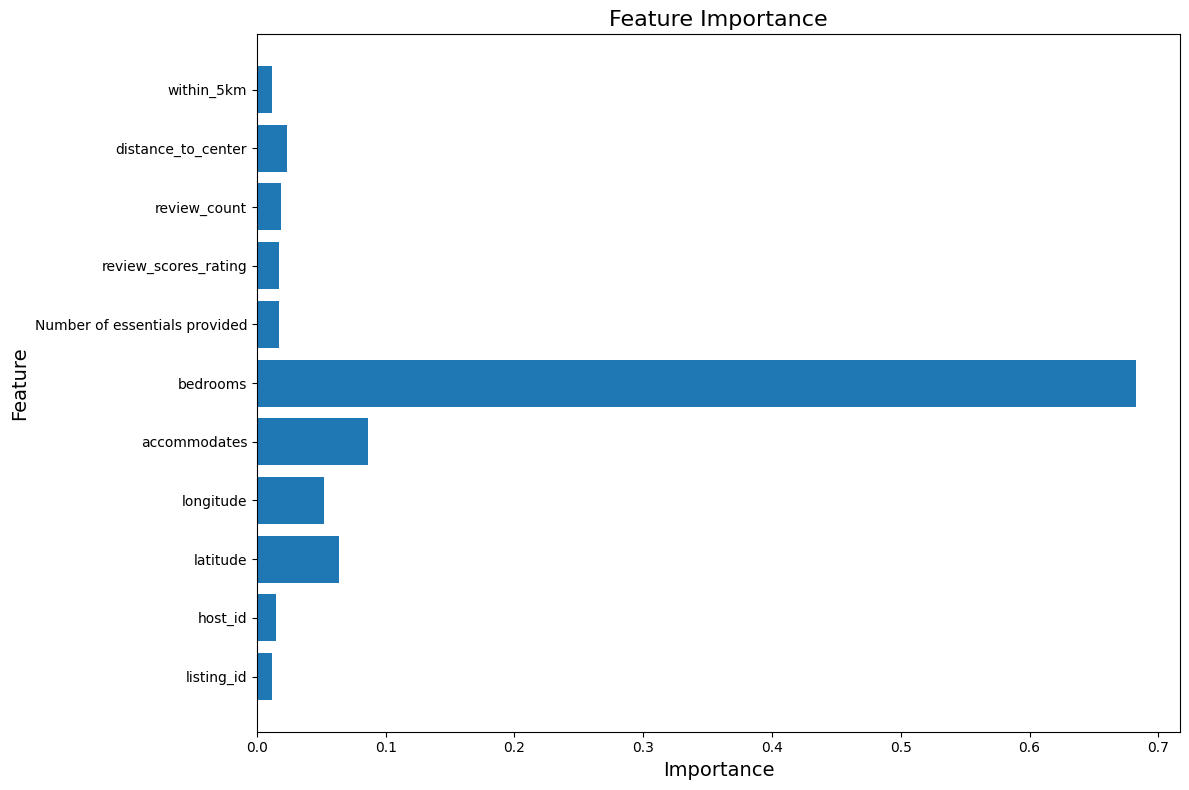

In [ ]:
# Plot the feature importance
plt.figure(figsize=(12, 8))
plt.barh(X_train_non_city.columns, best_model.feature_importances_)
plt.title("Feature Importance", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

Key Takeaways


*   After varying the max_depth range, we settled on a range of [1,3] because that minimized overfitting and minimized the importance of city_Istanbul. Unfortunately, after hyperparameter tuning, the XGBoost model still relies too heavily on city_Istanbul, with this feature being the most important feature.
*   With a higher range of max_depth, the $R^2$ score was higher but the reliance on city_Istanbul was also higher.
*   This highlights a shortcoming of XGBoost:
because its tree-based structure prioritizes features that reduce the most error at each split, it relies too heabily on city_Istanbul. If city_Istanbul strongly correlates with certain price patterns (higher prices), the model identifies it as the most significant factor, often at the expense of other features. This over-reliance is further amplified if the data is imbalanced, with Istanbul exhibiting a skewed distribution, especially after transformations like log(y).



In [ ]:
#Define the XGBoost model
SEED = 42
cv = KFold(n_splits=3, shuffle=True, random_state=SEED)
xgb_model = XGBRegressor(random_state=SEED)

#Define the paramter grid
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [10, 15],
    "learning_rate": [0.1, 0.2],
    "random_state": [42]
}
#Instantiate the random search model
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,
    cv=cv,
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=SEED,
)

#Fit random search, find R^2 value on best model.
random_search.fit(X_train_non_city, y_train)
best_xgb_model = random_search.best_estimator_
y_pred = best_xgb_model.predict(X_test_non_city)
r2 = r2_score(y_test, y_pred)
print(f"R² with hyperparameter tuning: {r2:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END learning_rate=0.1, max_depth=10, n_estimators=50, random_state=42; total time=   9.9s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=50, random_state=42; total time=   3.8s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=50, random_state=42; total time=   3.0s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, random_state=42; total time=  13.5s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, random_state=42; total time=   7.5s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, random_state=42; total time=   7.9s
[CV] END learning_rate=0.1, max_depth=15, n_estimators=50, random_state=42; total time=   5.9s
[CV] END learning_rate=0.1, max_depth=15, n_estimators=50, random_state=42; total time=  12.0s
[CV] END learning_rate=0.1, max_depth=15, n_estimators=50, random_state=42; total time=   6.1s
[CV] END learning_rate=0.1, max_depth=15, n_estimators=100, random_state=42; total

We used random search for hyperparameter tuning here, because random search resulted in a better model for Random Forest. However, for XGBoost, grid search actually yielded a better $R^2$ score of 0.62 versus a score of 0.6164 for random search.

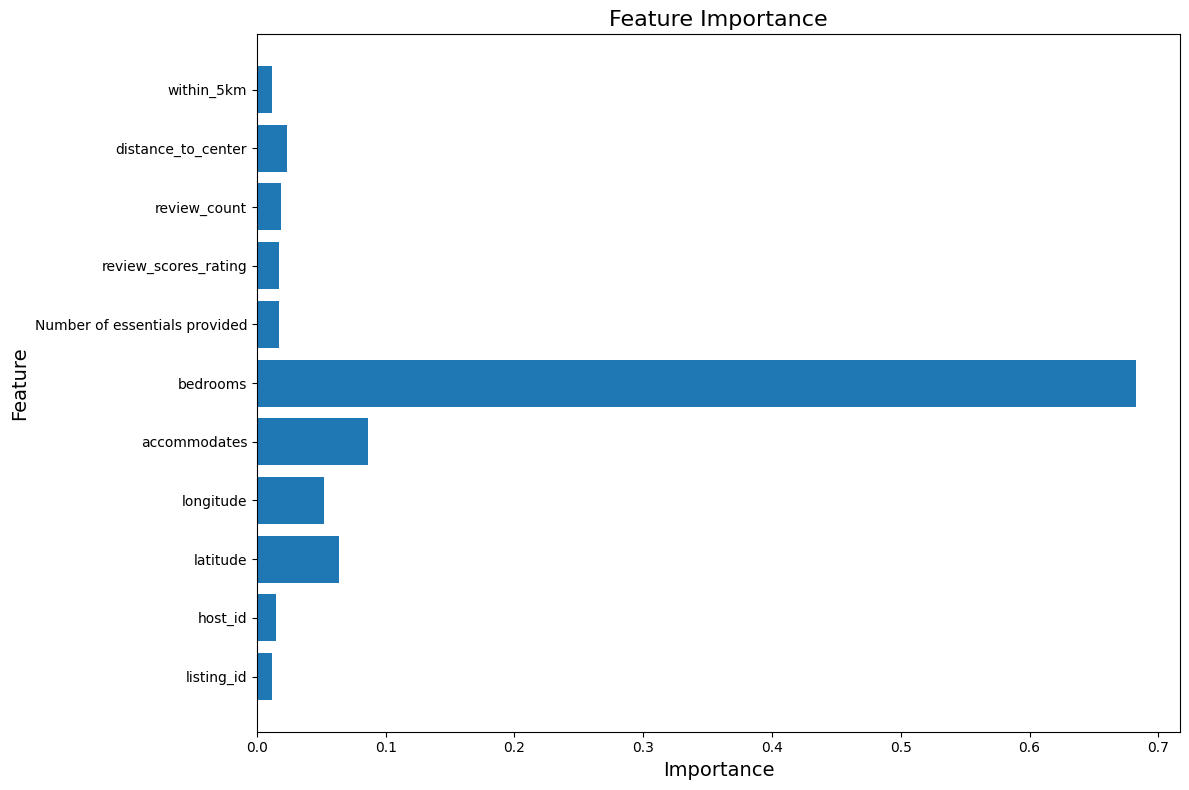

In [ ]:
# Plot the feature importance
plt.figure(figsize=(12, 8))
plt.barh(X_train_non_city.columns, best_model.feature_importances_)
plt.title("Feature Importance", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

With random search, Istanbul still has the highest feature importance with up to 0.35. The best performing XGBoost model was with learning_rate = 0.1, max_depth = 10, n_estimators = 100, and random_state = 42, found using grid search.

### 5.4.4 Hypothesis Testing

Null Hypothesis: The XGBoost model’s performance as measured by $R^2$ value is not better than random chance.

Alternative Hypothesis: the XGBoost model’s performance as measured by $R^2$ value is better than random chance.

We set the significance level to be 0.05.


In [ ]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.utils import shuffle

best_xgb_model.fit(X_train_non_city, y_train)
y_pred = best_xgb_model.predict(X_test_non_city)

original_r2 = r2_score(y_test, y_pred)
print(f"Original R²: {original_r2:.4f}")

n_permutations = 1000
simulated_r2 = []

for _ in range(n_permutations):
    y_test_shuffled = np.random.permutation(y_test)
    simulated_r2.append(r2_score(y_test_shuffled, y_pred))

p_value = np.mean(np.array(simulated_r2) >= original_r2)
print(f"p-value: {p_value:.4f}")

Original R²: 0.6164
p-value: 0.0000


Because the p-value = 0 < significance level of 0.05, we reject the null hypothesis. This means that the model's performance is statistically significant and not due to random chance.

The permutation test results, shown in the graph below, illustrate the distribution of $R^2$ values generated under the null hypothesis. The original model's $R^2$ (marked by the red dashed line) lies far beyond the $R^2$ score for all simulations in the null world, supporting the conclusion that the observed performance is unlikely due to random chance.

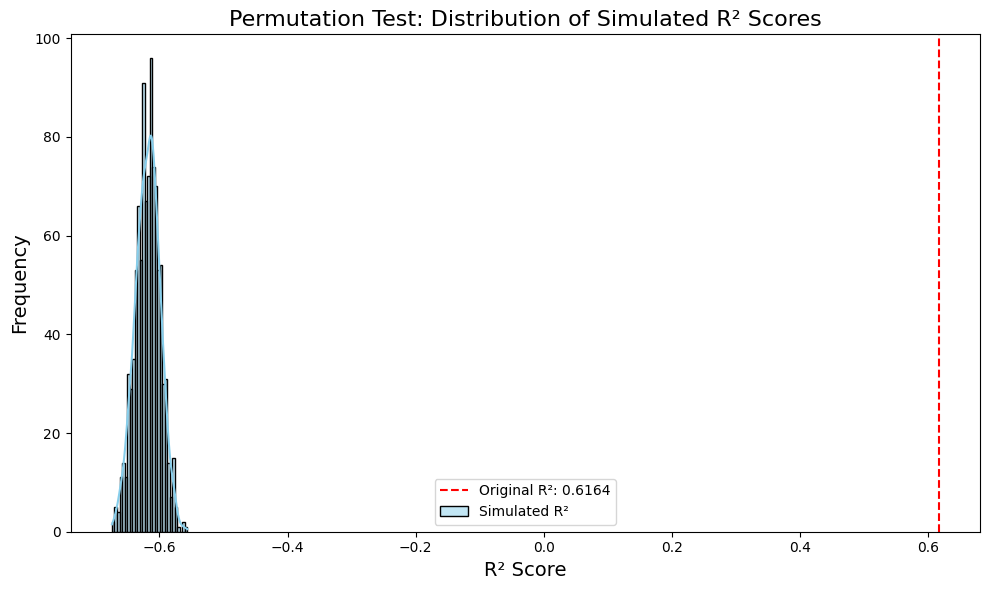

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(simulated_r2, kde=True, color='skyblue', label='Simulated R²', bins=30)
plt.axvline(original_r2, color='red', linestyle='--', label=f'Original R²: {original_r2:.4f}')
plt.title('Permutation Test: Distribution of Simulated R² Scores', fontsize=16)
plt.xlabel('R² Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

### 5.4.5 Bootstrapping

In [ ]:
n_bootstraps = 500
bootstrap_r2 = []

for _ in range(n_bootstraps):
    resample_indices = np.random.choice(len(X_train_non_city), size=len(X_train_non_city), replace=True)
    X_train_resampled = X_train_non_city.iloc[resample_indices]
    y_train_resampled = y_train.iloc[resample_indices]

    bootstrap_model = clone(best_model)
    bootstrap_model.fit(X_train_resampled, y_train_resampled)

    y_pred_bootstrap = bootstrap_model.predict(X_test_non_city)
    r2 = r2_score(y_test, y_pred_bootstrap)
    bootstrap_r2.append(r2)

bootstrap_mean_r2 = np.mean(bootstrap_r2)
bootstrap_ci_lower = np.percentile(bootstrap_r2, 2.5)
bootstrap_ci_upper = np.percentile(bootstrap_r2, 97.5)

print(f"Bootstrap Mean R²: {bootstrap_mean_r2:.4f}")
print(f"95% Confidence Interval for R²: [{bootstrap_ci_lower:.4f}, {bootstrap_ci_upper:.4f}]")

Bootstrap Mean R²: 0.5913
95% Confidence Interval for R²: [0.5828, 0.5998]


Applying bootstrapping to estimate the confidence interval for the $R^2$ value shows a very narrow interval for 95% confidence, indicating that the model's performance is very reliable and stable.

In summary, the above tests demonstrate that the XGBoost model has meaningful predictive power and is not driven by randomness.


## 5.5 Continued Results

In terms of our models' performance, we found that a random forest model provided the best results with the highest achieved $R^2$ being 0.6104. This is likely due to the fact that random forest models are equipped to handle noisy data like ours where the correlations between the variables and to the target variable is not clear-cut and well-defined.

The next best model we created was using XGBoost. This model was also reasonably successful to due its non-assumption of linearity and it ability to model interactions between variables. This ability proved to be slightly worse than the random forest model's but this model was able to converge onto a result much faster while not sacrificing too much performance.

The worst non-baseline model was using Multiple Linear Regression. The coefficients on each variable tended to be very small, indicating that each variable has only a small effect on the overall predictive power of the model upon price, but when aggregated overall provides an interpretation with non-negligible correlation.

Note also that for Random Forest and XGBoost that using hyperparameter tuning increased the $R^2$ scores, meaning that we were able to uncover some more granularity in the relationships between the variables by changing certain parameters of the models.

# Part 6: Conclusion, Discussion, and Key Takeaways

**Feature Importance:**
*   Random Forest: `bedrooms` has the highest feature importance of almost 0.25 while `city_Istanbul` is the next most important feature with about 0.14 feature importance.
    * All other cities have low feature importance, indicating there is little variance in the city prices (normalized to USD) & low correlation between city and price.

*   MLR: Number of amenities provided had the highest absolute value of coefficients at a positive 0.02752.
    * Although all features had a small coefficient, they can still contribute to price variation over large datasets by adding up across listings.

*   XGBoost: Bedrooms were the top feature, with almost 0.7 feature importance.
    * More bedrooms increase maintenance costs and prices.

**Modeling Implications:**
Hosts should prioritize optimizing property size (e.g. bedrooms) and amenities since location has less impact. Highlighting features like bedrooms and capacity can attract more bookings for Airbnb hosts. For guests, understanding that property size (e.g. bedrooms) and amenities drive pricing more than location can help them make informed decisions. Guests can focus on properties with features that match their needs without overvaluing location, potentially finding better deals.


**Limitations:**
Our dataset proved to be our biggest limitation. We initially selected it due to its high usability rating of 9.41/10 on Kaggle, but it quickly became clear that the dataset had significant issues. The raw data included unrealistic prices, such as \$106,000 for a single night. Even after cleaning the dataset and dropping null values, the maximum price was \$21,943. Removing the top 0.035% of outliers brought the max down to was still a very high \$5,400, which still seemed unreasonably high for a one-night stay.

After creating EDAs, we realized there was little to no correlation between some of our features & the price. Additionally, our models Random Forest & XGBoost relied too heavily on city_Istanbul due to a heavy right skew of prices.

**Potential Improvement/Future Work:**

*   Integrate temporal data, such as booking season, local events, and holidays, to better capture fluctuations in pricing.

*   Experimenting with neural networks.

*   Performing NLP on real reviews.

*   Analyze customer reviews for sentiment to understand how positive or negative feedback impacts pricing and demand.

